**IMPORTANTE**: Depués de ejecutar la siguiente celda, es probable que aparezca un Warning indicando que se debe reiniciar el entorno de ejecución.    
**ACCIÓN RECOMENDABLE**: Ejecutar unicamente la siguiente celda, luego reiniciar el entorno y ejecutar todo (botón "Entorno de ejecución", opción "Reiniciar y ejecutar todo").

In [ ]:
%pip install numpy==1.19

In [ ]:
%pip install tensorflow==2.1
%matplotlib inline

In [ ]:
# Importamos TensorFlow y Keras
import tensorflow as tf
import tensorflow.keras as keras
# Importamos el modelo Sequential
from tensorflow.keras.models import Sequential
# Importamos las capas que utilizaremos
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPool1D, LSTM, GRU

# Importamos el normalizador de los datos
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#importamos los optimizadores
from tensorflow.keras.optimizers import RMSprop, Adam

# Importamos el evaluador de la predicción
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Importamos las librerias de análisis de datos
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime, random, math
# Dependencia necesaria para descomponer las graficas y corroborar su estacionalidad. 
from statsmodels.tsa.seasonal import seasonal_decompose

# Controlamos la aleatoriedad con una semilla 
np.random.seed(42)
tf.random.set_seed(42)

# Controlamos los warning
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


**Obs**: La ruta especificada para acceder al archivo debe ser la perteneciente a la carpeta en la que se guardo. En este caso fue data. 

In [ ]:
%cd 'drive/MyDrive/data'

/content/drive/MyDrive/data


# Revisando el Dataset del consumo eléctrico nacional

El archivo a continuación fue descargado de http://energiaabierta.cl/certificados/ (Demanda diaria). El siguiente posee información diaria en MW de la demanda electrica en Chile desde el año 2006 al 2021.   
Donde se tiene:   
- Enero 2006 hasta diciembre 2017: Sistema Interconectado Central (SIC) y Sistema Interconectado del Norte Grande (SING).   
- Enero 2018 hasta septiembre 2021: Sistema Electrico Nacional (SEN).   
**Obs: El sistema SEN corresponde al resultado de la unión del sistema SIC y SING.*

In [ ]:
df = pd.read_csv('demanda_electrica_diaria.csv')
data_electrica = df[['fecha','sistema','dmin','dmax']]
data_electrica

,fecha,sistema,dmin,dmax
0,01/01/2006,SIC,2644.20,4221.86
1,01/01/2006,SING,1379.91,1547.89
2,02/01/2006,SIC,3078.20,5233.15
3,02/01/2006,SING,1416.14,1552.15
4,03/01/2006,SIC,3639.14,5315.77
...,...,...,...,...
10094,26/09/2021,SEN,7634.18,9504.99
10095,27/09/2021,SEN,7811.68,10141.44
10096,28/09/2021,SEN,8050.98,9874.77
10097,29/09/2021,SEN,7676.11,9884.11


**Veremos los tipos de datos que tenemos en el DataFrame**

In [ ]:
data_electrica.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10099 entries, 0 to 10098
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   fecha    10099 non-null  object 
 1   sistema  10099 non-null  object 
 2   dmin     10099 non-null  float64
 3   dmax     10099 non-null  float64
dtypes: float64(2), object(2)
memory usage: 315.7+ KB


In [ ]:
# Transformaremos la columna fecha que se encuentra en formato "string" (object) a formato "fecha" (datetime)
data_electrica['fecha'] = pd.to_datetime(data_electrica['fecha'], format='%d/%m/%Y')
# Luego dejaremos nuestra columna fecha como indice del DataFrame
data_electrica = data_electrica.set_index('fecha')
# Transformaremos la columna sistema que se encuentra en formato "string" (object) a formato "categorico" (category)
data_electrica['sistema'] = data_electrica['sistema'].astype('category')

In [ ]:
# Luego tenemos los formatos que queremos.
data_electrica.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10099 entries, 2006-01-01 to 2021-09-30
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   sistema  10099 non-null  category
 1   dmin     10099 non-null  float64 
 2   dmax     10099 non-null  float64 
dtypes: category(1), float64(2)
memory usage: 246.7 KB


## Breve resumen de la distribución y tendencia central de los sistemas del dataset

In [ ]:
# Veremos que tenemos 3 categorias en la columna sistema
data_electrica['sistema'].unique()

['SIC', 'SING', 'SEN']
Categories (3, object): ['SEN', 'SIC', 'SING']

**Los cuales son:**  
- **SIC: Sistema Interconectado Central**   
- **SING: Sistema Interconectado del Norte Grande**   
- **SEN: Sistema Eléctrico Nacional**

**DIAGRAMA DE CAJA DE LA DEMANDA MÍNIMA DE LOS 3 SISTEMAS**

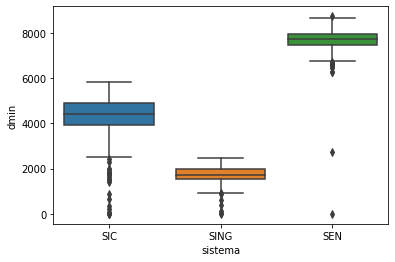

In [ ]:
sns.boxplot(data = df, x = 'sistema', y='dmin')
plt.show()

**Obs**: Se puede observar la presencia de datos atípicos u outliers.

**DIAGRAMA DE CAJA DE LA DEMANDA MÁXIMA DE LOS 3 SISTEMAS**

---



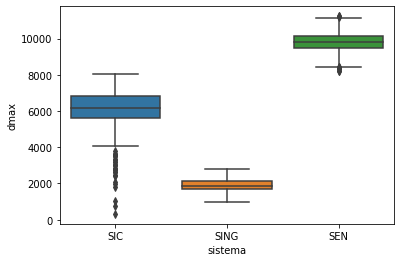

In [ ]:
sns.boxplot(data = df, x = 'sistema', y='dmax')
plt.show()

**Obs**: Se puede observar la presencia de datos atípicos u outliers.

## Separando la data

**Dividiremos el DF en 3 (SIC, SING y SEN) y veremos la cantidad de datos y fechas que disponemos**

In [ ]:
# Dividimos la data según los sitemas
data_sic = data_electrica[data_electrica['sistema'] == 'SIC']
data_sing = data_electrica[data_electrica['sistema'] == 'SING']
data_sen = data_electrica[data_electrica['sistema'] == 'SEN']

In [ ]:
print(f'Tenemos un total de {data_sic.shape[0]} datos en el sistema SIC')
print(f'Tenemos un total de {data_sing.shape[0]} datos en el sistema SING')
print(f'Tenemos un total de {data_sen.shape[0]} datos en el sistema SEN')

Tenemos un total de 4347 datos en el sistema SIC
Tenemos un total de 4383 datos en el sistema SING
Tenemos un total de 1369 datos en el sistema SEN


**Fechas en las que se encuentran los datos**

In [ ]:
print(f'El sistema SIC dispone de {data_sic.index.min()} hasta {data_sic.index.max()}')
print(f'El sistema SING dispone de {data_sing.index.min()} hasta {data_sing.index.max()}')
print(f'El sistema SEN dispone de {data_sen.index.min()} hasta {data_sen.index.max()}')

El sistema SIC dispone de 2006-01-01 00:00:00 hasta 2017-12-31 00:00:00
El sistema SING dispone de 2006-01-01 00:00:00 hasta 2017-12-31 00:00:00
El sistema SEN dispone de 2018-01-01 00:00:00 hasta 2021-09-30 00:00:00


## Viendo el comportamiento de los datos de SIC

In [ ]:
data_sic

,sistema,dmin,dmax
fecha,,,
2006-01-01,SIC,2644.20,4221.86
2006-01-02,SIC,3078.20,5233.15
2006-01-03,SIC,3639.14,5315.77
2006-01-04,SIC,3743.20,5252.27
2006-01-05,SIC,3719.60,5344.07
...,...,...,...
2017-12-27,SIC,5392.11,8050.35
2017-12-28,SIC,5781.89,8071.90
2017-12-29,SIC,5716.63,7778.71


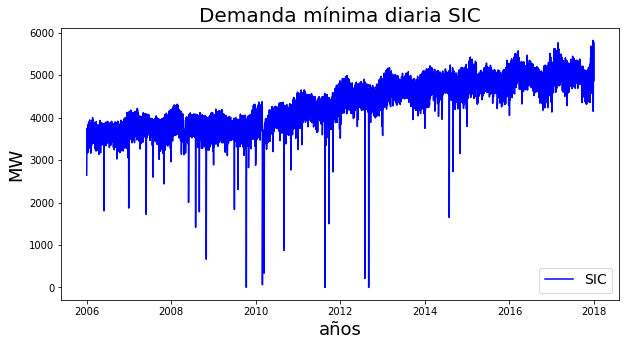

In [ ]:
# Comenzamos por ver la demanda mínima del SIC
plt.figure(figsize=(10,5))
plt.plot(data_sic['dmin'], c='b', label = 'SIC')
plt.title('Demanda mínima diaria SIC', fontsize = 20)
plt.xlabel('años', fontsize = 18)
plt.ylabel('MW', fontsize = 18)
plt.legend(loc = 'lower right', fontsize = 14)
plt.show()

Es posible observar muchos datos outliers y dada la cantidad de datos diarios no se logra visualizar bien. Se almacenará en una variable el df transformado a la demanda mensual del año 2006 al año 2017 

In [ ]:
data_sic_mes = data_sic.resample('M').sum()
data_sic_mes

,dmin,dmax
fecha,,
2006-01-31,112820.06,161805.57
2006-02-28,104529.33,149664.51
2006-03-31,115299.48,174691.74
2006-04-30,108889.94,168611.30
2006-05-31,109148.61,154662.59
...,...,...
2017-08-31,160069.99,226206.79
2017-09-30,150048.65,206833.48
2017-10-31,150160.46,211177.09


**Veremos su comportamiento mensual cada año**

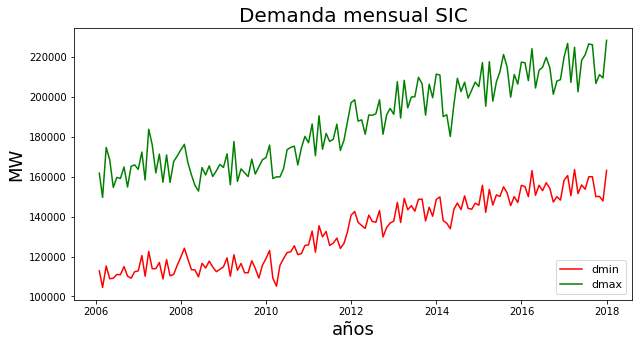

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(data_sic_mes['dmin'], c='r', label = 'dmin')
#plt.plot(data_sic_mes['dmean'], c='b', label = 'dmean')
plt.plot(data_sic_mes['dmax'], c = 'g', label = 'dmax')
plt.title('Demanda mensual SIC', fontsize = 20)
plt.xlabel('años', fontsize = 18)
plt.ylabel('MW', fontsize = 18)
plt.legend(loc = 'lower right', fontsize = 11)
plt.show()

**Revisaremos los últimos 3 años para ver si existe estacionalidad**

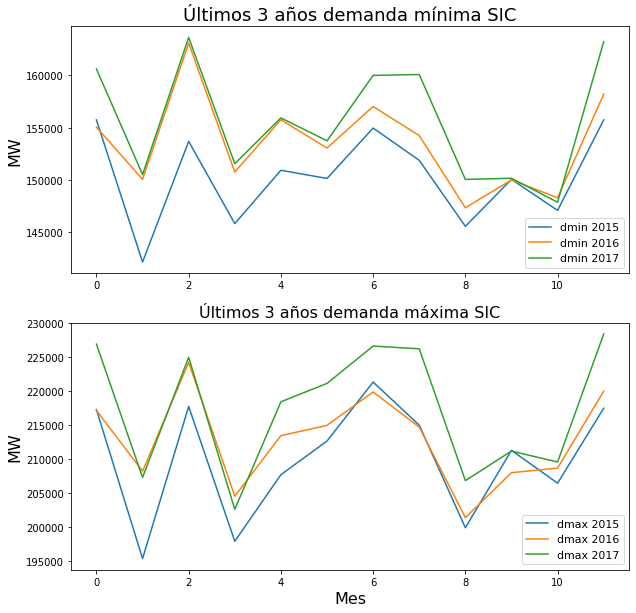

In [ ]:
fig = plt.figure(figsize=(10,10))

ax = plt.subplot(2,1,1)
ax.plot(data_sic_mes['dmin'].loc['2015'].values, label = 'dmin 2015')
ax.plot(data_sic_mes['dmin'].loc['2016'].values, label = 'dmin 2016')
ax.plot(data_sic_mes['dmin'].loc['2017'].values, label = 'dmin 2017')
plt.title('Últimos 3 años demanda mínima SIC', fontsize = 18)
plt.ylabel('MW', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 11)

ax = plt.subplot(2,1,2)
ax.plot(data_sic_mes['dmax'].loc['2015'].values, label = 'dmax 2015')
ax.plot(data_sic_mes['dmax'].loc['2016'].values, label = 'dmax 2016')
ax.plot(data_sic_mes['dmax'].loc['2017'].values, label = 'dmax 2017')
plt.title('Últimos 3 años demanda máxima SIC', fontsize = 16)
plt.xlabel('Mes', fontsize = 16)
plt.ylabel('MW', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 11)


plt.show()

**Obs**: Podemos ver a simple vista un comportamiento estacional de la demanda en el sistema SIC.

Corroborando la estacionalidad de la demanda mínima de SIC

Figure(432x288)


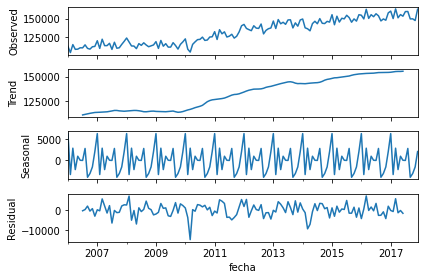

In [ ]:
print(seasonal_decompose(data_sic_mes['dmin']).plot())

Corroborando la estacionalidad de la demanda máxima de SIC

Figure(432x288)


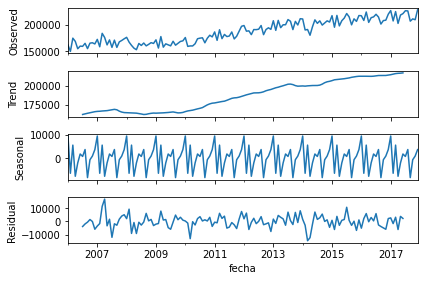

In [ ]:
print(seasonal_decompose(data_sic_mes['dmax']).plot())

## Viendo el comportamiento de los datos de SING

In [ ]:
data_sing

,sistema,dmin,dmax
fecha,,,
2006-01-01,SING,1379.91,1547.89
2006-01-02,SING,1416.14,1552.15
2006-01-03,SING,1417.51,1550.83
2006-01-04,SING,1416.68,1524.19
2006-01-05,SING,1444.52,1558.66
...,...,...,...
2017-12-27,SING,2101.56,2572.70
2017-12-28,SING,2184.96,2543.82
2017-12-29,SING,2269.60,2513.26


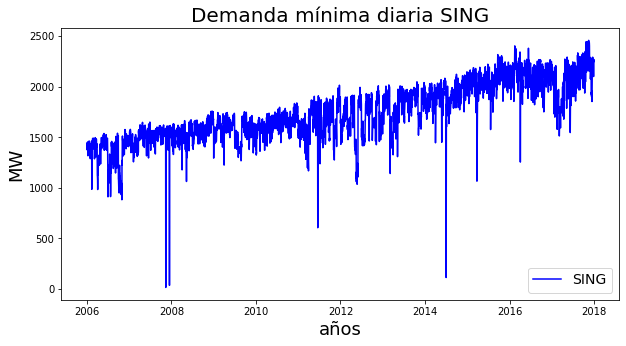

In [ ]:
# Comenzamos por ver la demanda mínima del SING
plt.figure(figsize=(10,5))
plt.plot(data_sing['dmin'], c='b', label = 'SING')
plt.title('Demanda mínima diaria SING', fontsize = 20)
plt.xlabel('años', fontsize = 18)
plt.ylabel('MW', fontsize = 18)
plt.legend(loc = 'lower right', fontsize = 14)
plt.show()

Es posible observar muchos datos outliers y dada la cantidad de datos diarios no se logra visualizar bien. Se almacenará en una variable el df transformado a la demanda mensual del año 2006 al año 2017.

In [ ]:
data_sing_mes = data_sing.resample('M').sum()
data_sing_mes

,dmin,dmax
fecha,,
2006-01-31,43516.93,47585.62
2006-02-28,38718.80,42753.17
2006-03-31,43749.64,47727.71
2006-04-30,37740.73,42739.19
2006-05-31,45393.39,49431.31
...,...,...
2017-08-31,67584.01,74672.35
2017-09-30,65213.77,72714.60
2017-10-31,69468.23,77559.31


**Veremos su comportamiento mensual cada año**

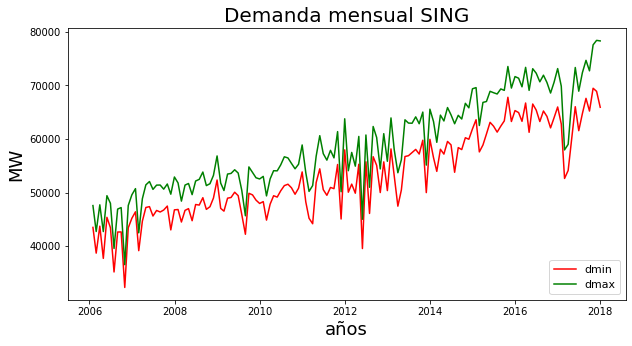

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(data_sing_mes['dmin'], c='r', label = 'dmin')
plt.plot(data_sing_mes['dmax'], c = 'g', label = 'dmax')
plt.title('Demanda mensual SING', fontsize = 20)
plt.xlabel('años', fontsize = 18)
plt.ylabel('MW', fontsize = 18)
plt.legend(loc = 'lower right', fontsize = 11)
plt.show()

**Revisaremos los últimos 3 años para ver si existe estacionalidad**

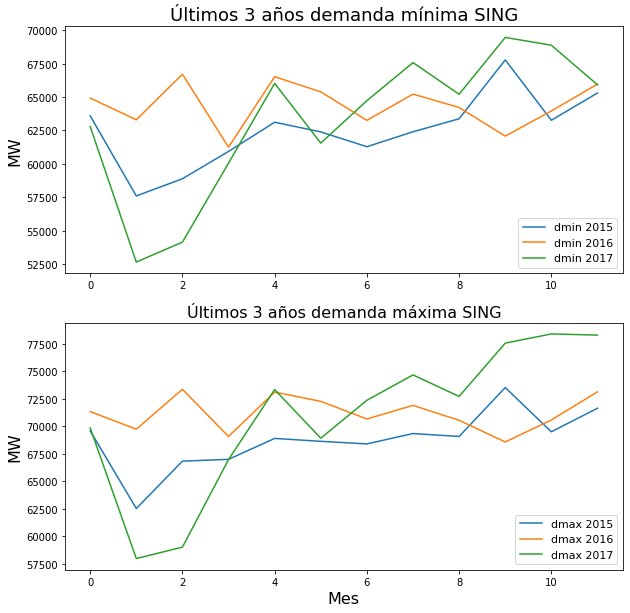

In [ ]:
fig = plt.figure(figsize=(10,10))

ax = plt.subplot(2,1,1)
ax.plot(data_sing_mes['dmin'].loc['2015'].values, label = 'dmin 2015')
ax.plot(data_sing_mes['dmin'].loc['2016'].values, label = 'dmin 2016')
ax.plot(data_sing_mes['dmin'].loc['2017'].values, label = 'dmin 2017')
plt.title('Últimos 3 años demanda mínima SING', fontsize = 18)
plt.ylabel('MW', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 11)

ax = plt.subplot(2,1,2)
ax.plot(data_sing_mes['dmax'].loc['2015'].values, label = 'dmax 2015')
ax.plot(data_sing_mes['dmax'].loc['2016'].values, label = 'dmax 2016')
ax.plot(data_sing_mes['dmax'].loc['2017'].values, label = 'dmax 2017')
plt.title('Últimos 3 años demanda máxima SING', fontsize = 16)
plt.xlabel('Mes', fontsize = 16)
plt.ylabel('MW', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 11)

plt.show()

**Obs**: Podemos ver a simple vista que no existe estacionalidad de la demanda en el sistema SING

Corroborando la estacionalidad de la demanda mínima de SING

Figure(432x288)


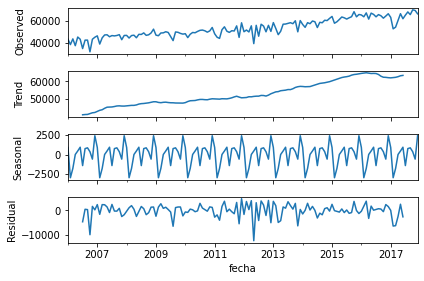

In [ ]:
print(seasonal_decompose(data_sing_mes['dmin']).plot())

Corroborando la estacionalidad de la demanda máxima de SING

Figure(432x288)


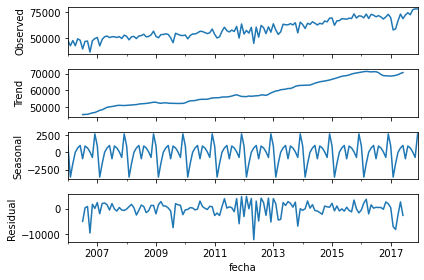

In [ ]:
print(seasonal_decompose(data_sing_mes['dmax']).plot())

## Viendo el comportamiento de los datos de SEN

In [ ]:
data_sen

,sistema,dmin,dmax
fecha,,,
2018-01-01,SEN,6734.33,8660.14
2018-01-02,SEN,7329.54,10033.64
2018-01-03,SEN,7917.84,10139.43
2018-01-04,SEN,8007.40,9934.52
2018-01-05,SEN,8030.03,10005.76
...,...,...,...
2021-09-26,SEN,7634.18,9504.99
2021-09-27,SEN,7811.68,10141.44
2021-09-28,SEN,8050.98,9874.77


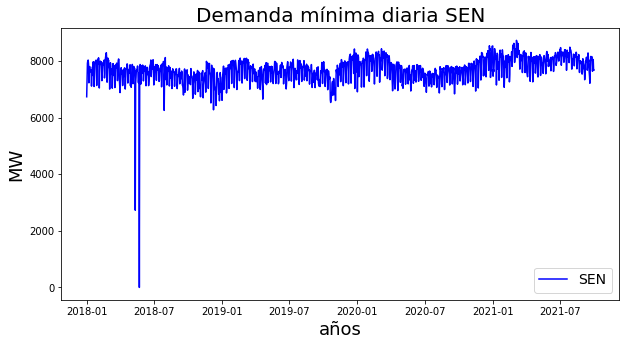

In [ ]:
# Graficaremos la data para poder visualizar su comportamiento (dmin)
plt.figure(figsize=(10,5))
plt.plot(data_sen['dmin'], c='b', label = 'SEN')
plt.title('Demanda mínima diaria SEN', fontsize = 20)
plt.xlabel('años', fontsize = 18)
plt.ylabel('MW', fontsize = 18)
plt.legend(loc = 'lower right', fontsize = 14)
plt.show()

Es posible observar datos atípicos, pero mucho menos que el sistema SIC y SING, pero dada la cantidad de datos diarios no se logra visualizar bien. Se almacenará en una variable el df transformado a la demanda mensual del año 2018 al año 2021.

In [ ]:
data_sen_mes = data_sen.resample('M').sum()
data_sen_mes.head() # Mostramos los primeros 5 meses de SEN

,dmin,dmax
fecha,,
2018-01-31,238161.49,301139.86
2018-02-28,219496.97,274969.26
2018-03-31,237317.29,298972.78
2018-04-30,225731.70,277336.24
2018-05-31,222440.37,294239.37


**Veremos su comportamiento mensual cada año**

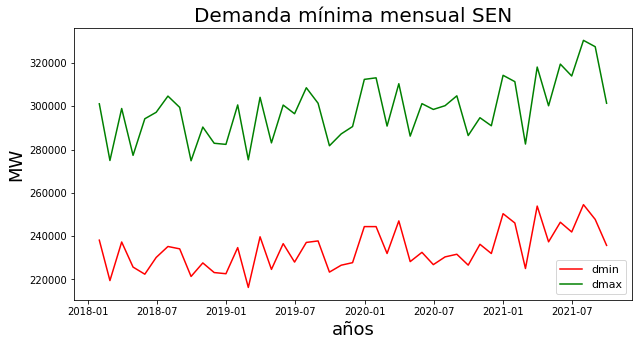

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(data_sen_mes['dmin'], c='r', label = 'dmin')
plt.plot(data_sen_mes['dmax'], c = 'g', label = 'dmax')
plt.title('Demanda mínima mensual SEN', fontsize = 20)
plt.xlabel('años', fontsize = 18)
plt.ylabel('MW', fontsize = 18)
plt.legend(loc = 'lower right', fontsize = 11)
plt.show()

**Revisaremos los ultimos 3 años para ver si existe estacionalidad**   
obs: Como el año 2021 no esta completo, veremos del 2020 hacia atras.

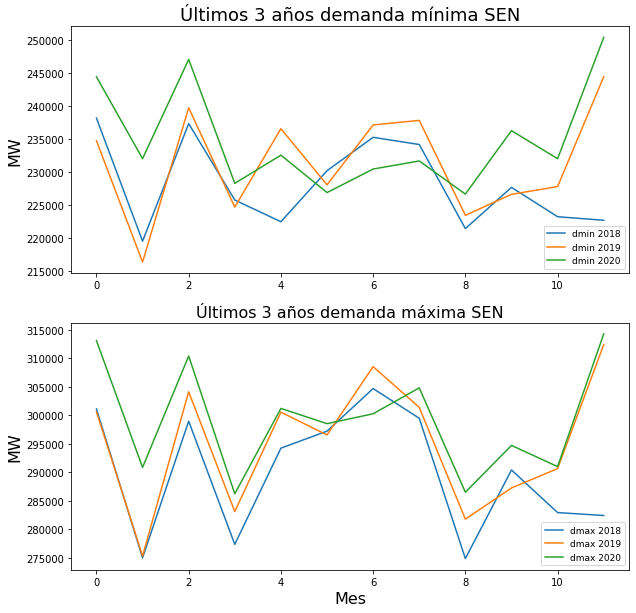

In [ ]:
fig = plt.figure(figsize=(10,10))

ax = plt.subplot(2,1,1)
ax.plot(data_sen_mes['dmin'].loc['2018'].values, label = 'dmin 2018')
ax.plot(data_sen_mes['dmin'].loc['2019'].values, label = 'dmin 2019')
ax.plot(data_sen_mes['dmin'].loc['2020'].values, label = 'dmin 2020')
plt.title('Últimos 3 años demanda mínima SEN', fontsize = 18)
plt.ylabel('MW', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 9)

ax = plt.subplot(2,1,2)
ax.plot(data_sen_mes['dmax'].loc['2018'].values, label = 'dmax 2018')
ax.plot(data_sen_mes['dmax'].loc['2019'].values, label = 'dmax 2019')
ax.plot(data_sen_mes['dmax'].loc['2020'].values, label = 'dmax 2020')
plt.title('Últimos 3 años demanda máxima SEN', fontsize = 16)
plt.xlabel('Mes', fontsize = 16)
plt.ylabel('MW', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 9)

plt.show()

**Obs**: Podemos ver a simple vista un comportamiento estacional de la demanda en el sistema SEN.

Corroborando la estacionalidad de la demanda mínima de SEN

Figure(432x288)


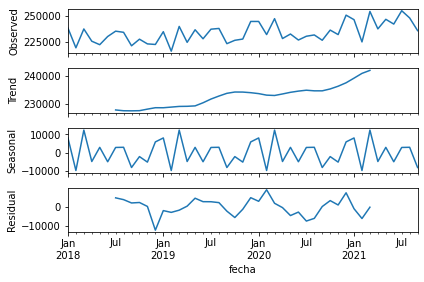

In [ ]:
print(seasonal_decompose(data_sen_mes['dmin']).plot())

Corroborando la estacionalidad de la demanda máxima de SEN

Figure(432x288)


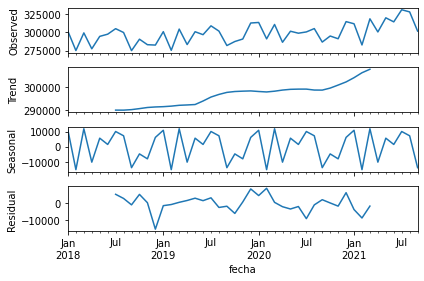

In [ ]:
print(seasonal_decompose(data_sen_mes['dmax']).plot())

# Funciones a utilizar en el proyecto

In [ ]:
## FUNCIONES PARA EL AJUSTE

# Con esta función obtendremos información numérica del dataset
def info_data(data, dmand:str):
  rango = round((data[dmand].max() - data[dmand].min()),2)
  min = data[dmand].min()
  Q1 = data[dmand].quantile(q=0.25)
  Q2 = data[dmand].quantile(q=0.50)
  Q3 = data[dmand].quantile(q=0.75)
  max = data[dmand].max()
  iqr = round((Q3 - Q1),2)
  count = data[dmand].count()
  mean = round(data[dmand].mean(),2)
  std = round(data[dmand].std(),2)
  print(f'Count: {count}\nMinimo: {min}\nMaximo: {max}\nRango: {rango}')
  print(f'Q1: {Q1}\nQ2: {Q2}\nQ3: {Q3}\nIQR: {iqr}\nMean: {mean}\nStd: {std}')

# En esta función ajustamos la data dado el rango intercuartil de esta, presentando además una tabla de los 
# datos outliers que fueron reemplazados por una media movil de 3 periodos anteriores. 
def ajust_media_movil(data, dmand:str):
  Q1 = data[dmand].quantile(q=0.25)
  Q3 = data[dmand].quantile(q=0.75)
  iqr = Q3 - Q1                       # Rango intercuartil (IQR)
  new_min = round(Q1 - 1.5*iqr,2)    # limite inferir  -> Q1 - 1.5IQR
  new_max = round(Q3 + 1.5*iqr,2)    # limite superior -> Q3 + 1.5IQR
  # Aquí quitamos la fecha de indice y la pasamos a columna, reseteando el indice a numeros. 
  data_ajust = data[[dmand]].rename_axis('fecha').reset_index()

  lista = []
  for index, valor in enumerate(data_ajust[dmand]):
    if (valor < new_min) or (valor > new_max):
      new_valor = round((data_ajust[[dmand]].loc[index-1][0]+data_ajust[[dmand]].loc[index-2][0]+data_ajust[[dmand]].loc[index-3][0])/3,2)
      lista.append([data_ajust['fecha'].loc[index], valor, new_valor])
      data_ajust[dmand][index] = new_valor

  changes = pd.DataFrame(lista, columns=['fecha','outlier','new_valor'])
  data_ajust = data_ajust.set_index('fecha')

  return data_ajust, changes

def graph_new_distribution(data_ajust, data, dmand:str):

  limit = (0,6000)
  if dmand == 'dmin':
    limit = (0,9000)
  else:
    limit = (6000,11500)
    
  figura = plt.figure(figsize=(20,10))
  ax = plt.subplot(1,2,1)
  ax.plot(data[[dmand]])
  plt.xlabel('Fecha', fontsize = 15)
  plt.ylabel('Distribución Original', fontsize =15)
  plt.ylim(limit)

  ax = plt.subplot(1,2,2)
  plt.xlabel('Fecha', fontsize = 15)
  plt.ylabel('Distribución Ajustada', fontsize = 15)
  ax.plot(data_ajust)
  plt.ylim(limit)

  plt.show()

  ## FUNCIONES PARA PODER APLICAR LOS MODELOS

  # La función encargada de transformar nuestra Serie Temporal en un problema de tipo supervisado.
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names 
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Función encargada de normalizar y transformar los datos a aprendizaje supervisado
def normalize_and_supervised(pronostic_mes):
  values = pronostic_mes.values
  values = values.astype('float32')
  # normalize features
  values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
  scaled = SCALER.fit_transform(values)
  transform_data = series_to_supervised(scaled, PAST_HISTORY,PREDICTION)

  return transform_data
  
# Función encargada de gráficar el proceso de entrenamiento del modelo
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  fig = plt.figure(figsize=(20,5))

  ax = plt.subplot(1,2,1)
  plt.ylabel('Loss - Mean Squared Error')
  ax.plot(hist['epoch'], hist['loss'], label= 'Train loss')
  ax.plot(hist['epoch'], hist['val_loss'], label='Validation loss')
  #plt.ylim(0.03,0.08)
  plt.legend()

  ax = plt.subplot(1,2,2)
  plt.ylabel('Mean Absolute Error')
  ax.plot(hist['epoch'], hist['mae'], label= 'Train Error')
  ax.plot(hist['epoch'], hist['val_mae'], label='Validation Error')
  #plt.ylim(0.0,0.025)
  plt.legend()

  plt.show()

# Función encargada de gráficar las predicciónes del modelo
def graph_prediction(index, test, predict):
  fig = plt.figure(figsize=(15,10))
  ax = plt.subplot(1,1,1)
  ax.plot(index ,test, c='b', label='Datos_test')
  ax.plot(index ,predict, '.-r', label='Predicción')
  plt.ylabel('MW', fontsize = 16)
  plt.xlabel('Fecha', fontsize = 16)
  plt.xticks(rotation=35, fontsize=14)
  plt.yticks(fontsize=14)
  ax.legend()
  plt.show()

# Funciones de MAPE y MAE creadas a partir de la expresión matemática. 
def mape(actual, pred):
  #actual, pred = np.array (actual), np.array (pred)
  return np.mean(np.abs((actual - pred)/actual))*100

def mae(actual, pred):
  return np.mean(np.abs(actual-pred)) 


# Función que resumen las graficas de las predicciones
def resumen_graficas(index, semana, mlp, lstm, gru, hibrido1, hibrido2, legend:str):
  # Comparando las graficas de x semana de predicción 
  '''
  index --> indices de la grafica; index_1_semana -> los primeros 7 días de septiembre y asi...(index_2_semana, ...)
  semana --> valores reales en dichas semanas; semana_1 -> valores de demanda real en la primera semana... (semana_2, ...)
  mlp --> valores predichos por el modelo indicando la semana; mlp_1_semana, mlp_2_semana, mlp_3_semana...
  lstm --> lo mismo que en mlp y los siguientes modelos...
  ...
  ...
  legend --> string que especifica la posición del legend de la grafica; 'lower left', ...
  '''
  fig = plt.figure(figsize=(15,15))
  
  ax = plt.subplot(3,2,1) # (3 filas, 2 columnas, primer gráfico)
  ax.plot(index, semana, c='g', label = 'datos_reales')
  ax.plot(index, mlp, '.-r', label = 'prediccion')
  plt.title('MLP', fontsize = 15)
  plt.ylabel('MW', fontsize = 18)
  plt.legend(loc = legend, fontsize = 11)
  plt.xticks(rotation=25)

  ax = plt.subplot(3,2,2) # (3 filas, 2 columnas, segundo gráfico)
  ax.plot(index, semana, c='g', label = 'datos_reales')
  ax.plot(index, lstm, '.-r', label = 'prediccion')
  plt.title('LSTM', fontsize = 15)
  plt.ylabel('MW', fontsize = 18)
  plt.legend(loc = legend, fontsize = 11)
  plt.xticks(rotation=25)

  ax = plt.subplot(3,2,3) # (3 filas, 2 columnas, tercer gráfico)
  ax.plot(index, semana, c='g', label = 'datos_reales')
  ax.plot(index, gru, '.-r', label = 'prediccion')
  plt.title('GRU', fontsize = 15)
  plt.ylabel('MW', fontsize = 18)
  plt.legend(loc = legend, fontsize = 11)
  plt.xticks(rotation=25)

  ax = plt.subplot(3,2,4) # (3 filas, 2 columnas, cuarto gráfico)
  ax.plot(index, semana, c='g', label = 'datos_reales')
  ax.plot(index, hibrido1, '.-r', label = 'prediccion')
  plt.title('HIBRIDO 1', fontsize = 15)
  plt.ylabel('MW', fontsize = 18)
  plt.xlabel('días', fontsize = 18)
  plt.legend(loc = legend, fontsize = 11)
  plt.xticks(rotation=25)

  ax = plt.subplot(3,2,5) # (3 filas, 2 columnas, quinto gráfico)
  ax.plot(index, semana, c='g', label = 'datos_reales')
  ax.plot(index, hibrido2, '.-r', label = 'prediccion')
  plt.title('HIBRIDO 2', fontsize = 15)
  plt.xlabel('días', fontsize = 18)
  plt.ylabel('MW', fontsize = 18)
  plt.legend(loc = legend, fontsize = 11)
  plt.xticks(rotation=25)

  fig.tight_layout()
  plt.show()

# PANEL DE CONTROL

In [ ]:
############## CONFIGURACIÓN GENERAL DE LOS MODELOS ########################################################
# Seleccionamos el rango para el aprendizaje supervisado ( t-n, t-(n-1), ... , t-2, t-1, t)
PAST_HISTORY = 30
PREDICTION = 1
# Generando el escalador de los datos.
SCALER = MinMaxScaler(feature_range=(0,1))
# Como se entrenara el modelo
LOSS = 'mean_squared_error'
OPTIMIZER_1 = Adam(learning_rate=0.0003)
OPTIMIZER_2 = RMSprop(learning_rate=0.0003) # un segundo optimizador para hacer pruebas
METRICS = ["mae"]

############# CONFIGURACIÓN MODELO ################################################################
# Función de activación
ACTIVATION = 'relu'
# Seleccionamos la cantidad de repeticiones que se entrenará (cantidad de EPOCH)
EPOCHS_1 = 40
EPOCHS_2 = 10

BATCH_SIZE = 32

# Preparando la data para los modelos

La data que se utilizará en este proyecto será la del Sistema Eléctrico Nacional (SEN), por varias razones: La primera es la calidad de la información en relación con los sistemas SIC y SING, donde ambos presentan muchos datos outliers y el segundo dudosa estacionalidad. La segunda razón es que el sistema SEN corresponde a los valores actuales de la generación eléctrica en Chile (recordemos que es la "fusión" del SIC y SING) y enfocar el proyecto en él hace que tenga más sentido hacer un pronóstico.

Se realizará un "Ajuste" de los datos para evitar los outliers presentes en el datasets. Esto, para obtener resultados más acordes al movimiento "real" de la demanda y facilitar el proceso de entrenamiento de los modelos. Se asumen estas bajas de demanda a efectos o situaciones extremas y no relevantes en su mayoría al comportamiento real de la demanda. El ajuste será dado el rango Inter cuartil (IQR), quién ayudará a establecer los nuevos límites en los que se encontrarán los datos.


#### Ajuste de SEN

**SEN dmin**

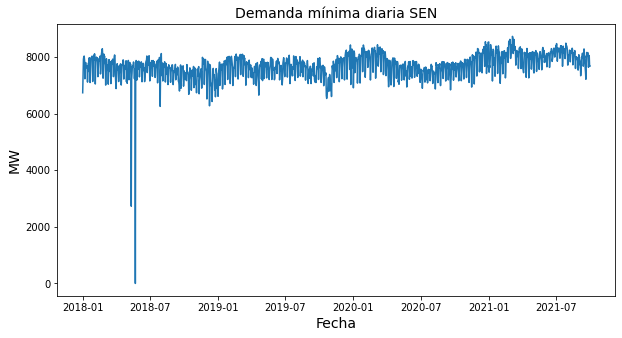

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(data_sen[['dmin']])
plt.title('Demanda mínima diaria SEN', fontsize=14)
plt.ylabel('MW', fontsize = 14)
plt.xlabel('Fecha', fontsize= 14)
plt.show()

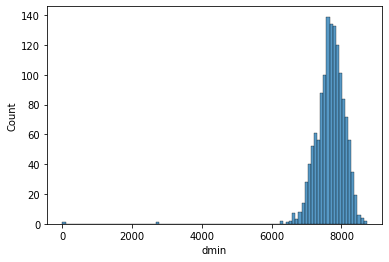

In [ ]:
# Vemos la distrubución de la demanda minima de SEN con un histograma
sns.histplot(data_sen['dmin'])
plt.show()

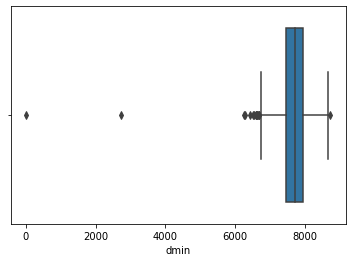

In [ ]:
# Veremos un diagrama de caja para ver la mediana, los quartiles y datos outliers de SEN dmin
sns.boxplot(data_sen['dmin'])
plt.show()

In [ ]:
# Veremos un poco de información de los datos (todos los valores estan en MW, menos Count)
info_data(data_sen, 'dmin')

Count: 1369
Minimo: 1.88
Maximo: 8726.74
Rango: 8724.86
Q1: 7462.11
Q2: 7711.29
Q3: 7956.83
IQR: 494.72
Mean: 7686.08
Std: 450.02


**Se realizará un ajuste de SEN dmin y dmax dado el rango intercuartil de los datos. En el proceso se detectarán los valores outliers o atípicos, quienes serán reemplazados por una media movil de los 3 días anteriores. Se determinó seguir este curso, ya que eliminar los datos no fue opción.   
Lo anterior se hará con las funciones definidas en "Funciones para el ajuste"**

In [ ]:
tratamiento_sen_dmin = ajust_media_movil(data_sen, 'dmin')
sen_dmin_ajust = tratamiento_sen_dmin[0]
changes_sen_dmin = tratamiento_sen_dmin[1]

In [ ]:
# Veremos los datos outliers con su correspondiente fecha y el valor por el que fueron reemplazados
changes_sen_dmin

,fecha,outlier,new_valor
0,2018-05-12,2728.94,7640.33
1,2018-05-23,1.88,7353.13
2,2018-07-29,6253.33,7913.98
3,2018-10-14,6678.47,7424.62
4,2018-11-11,6697.52,7538.36
5,2018-12-02,6515.90,7546.01
6,2018-12-09,6274.03,7582.95
7,2018-12-16,6425.55,7008.36
8,2018-12-25,6592.61,7096.42
9,2019-01-01,6609.30,7160.54


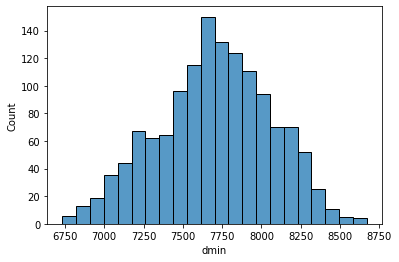

In [ ]:
# Vemos la distribución de los datos de SEN dmin ajustados
sns.histplot(sen_dmin_ajust['dmin'])
plt.show()

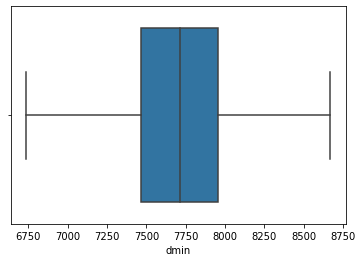

In [ ]:
# Podemos ver el gráfico de caja sin datos outliers. 
sns.boxplot(sen_dmin_ajust['dmin'])
plt.show()

In [ ]:
# Vemos un cambio en la información con los datos ajustados. 
info_data(sen_dmin_ajust,'dmin')

Count: 1369
Minimo: 6734.31
Maximo: 8669.49
Rango: 1935.18
Q1: 7464.02
Q2: 7711.42
Q3: 7956.83
IQR: 492.81
Mean: 7702.56
Std: 360.29


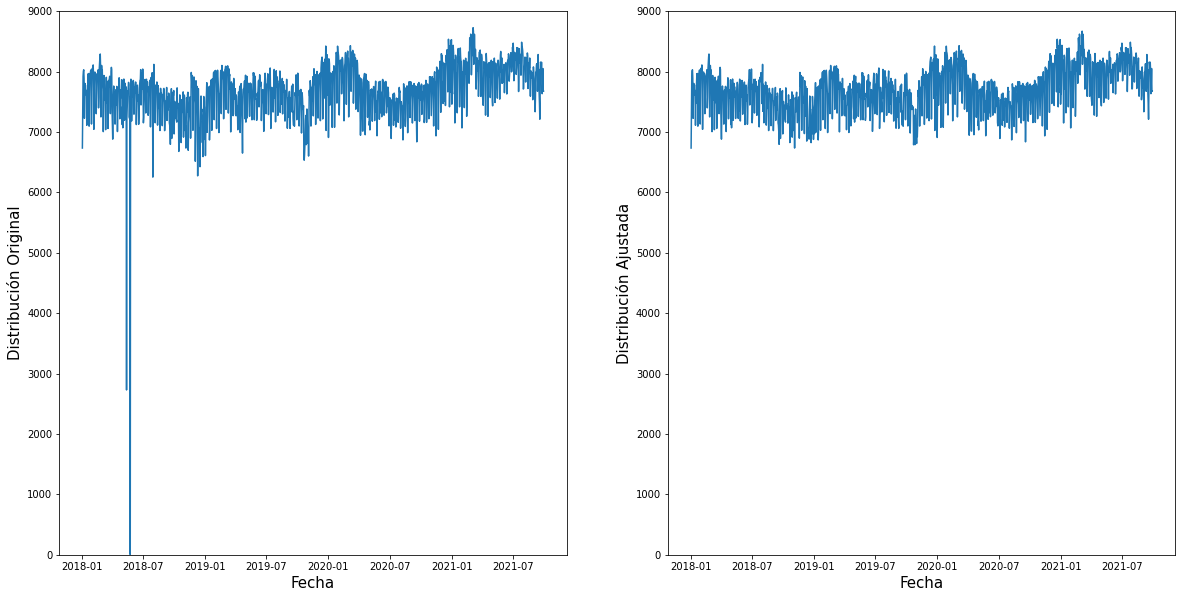

In [ ]:
# Hacemos una comparación de los datos antes (izquierda) y despues del ajuste intercuartil (derecha)
graph_new_distribution(sen_dmin_ajust, data_sen,'dmin')

**SEN dmax**

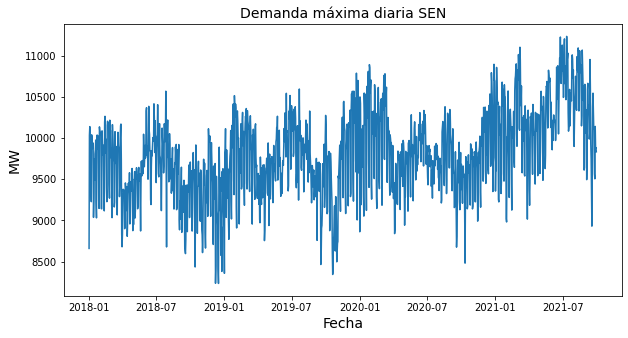

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(data_sen[['dmax']])
plt.title('Demanda máxima diaria SEN', fontsize=14)
plt.ylabel('MW', fontsize = 14)
plt.xlabel('Fecha', fontsize= 14)
plt.show()

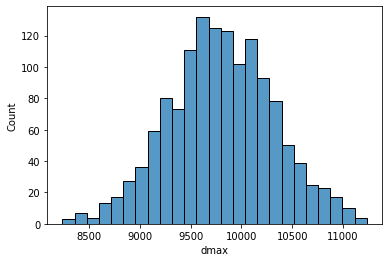

In [ ]:
# Vemos la distribución de los datos de SEN dmax con un histograma
sns.histplot(data_sen['dmax'])
plt.show()

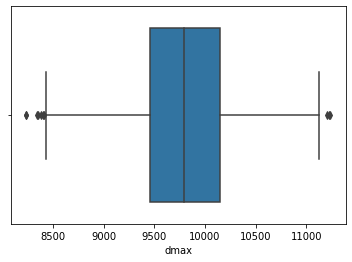

In [ ]:
# Veremos un diagrama de caja para ver la mediana, los cuartiles y datos outliers de SEN dmax
sns.boxplot(data_sen['dmax'])
plt.show()

In [ ]:
# Veremos un poco de información de los datos (todos los valores estan en MW, menos Count)
info_data(data_sen, 'dmax')

Count: 1369
Minimo: 8234.84
Maximo: 11235.16
Rango: 3000.32
Q1: 9459.19
Q2: 9789.38
Q3: 10152.75
IQR: 693.56
Mean: 9801.45
Std: 520.97


In [ ]:
# Se realiza el ajuste de los datos y se rescata el df con los datos outliers y sus nuevos valores.
tratamiento_sen_dmax = ajust_media_movil(data_sen, 'dmax')
sen_dmax_ajust = tratamiento_sen_dmax[0]
changes_sen_dmax = tratamiento_sen_dmax[1]

In [ ]:
# Veremos los datos outliers con su correspondiente fecha y el valor por el que fueron reemplazados
changes_sen_dmax

,fecha,outlier,new_valor
0,2018-12-08,8236.85,9504.84
1,2018-12-15,8406.11,9042.24
2,2018-12-16,8234.84,9018.55
3,2018-12-25,8380.68,8757.08
4,2019-01-01,8357.75,9062.79
5,2019-10-20,8343.64,9076.82
6,2019-10-21,8412.54,8974.58
7,2021-06-25,11226.90,10891.02
8,2021-07-06,11204.54,10698.55
9,2021-07-12,11235.16,10612.09


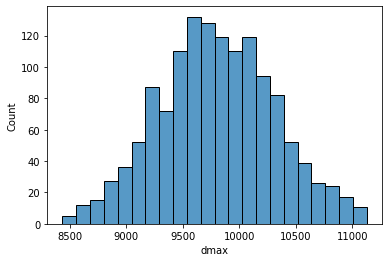

In [ ]:
# Vemos la distribución de los datos ajustados
sns.histplot(sen_dmax_ajust['dmax'])
plt.show()

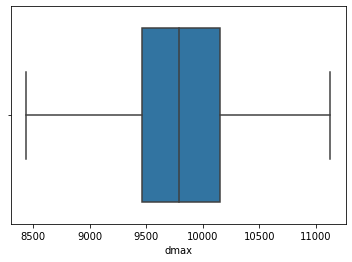

In [ ]:
# Vemos el gráfico de caja sin datos outliers.
sns.boxplot(sen_dmax_ajust['dmax'])
plt.show()

In [ ]:
# Vemos un cambio en la información con los datos ajustados.
info_data(sen_dmax_ajust,'dmax')

Count: 1369
Minimo: 8434.51
Maximo: 11128.55
Rango: 2694.04
Q1: 9459.59
Q2: 9789.38
Q3: 10152.75
IQR: 693.16
Mean: 9804.08
Std: 510.84


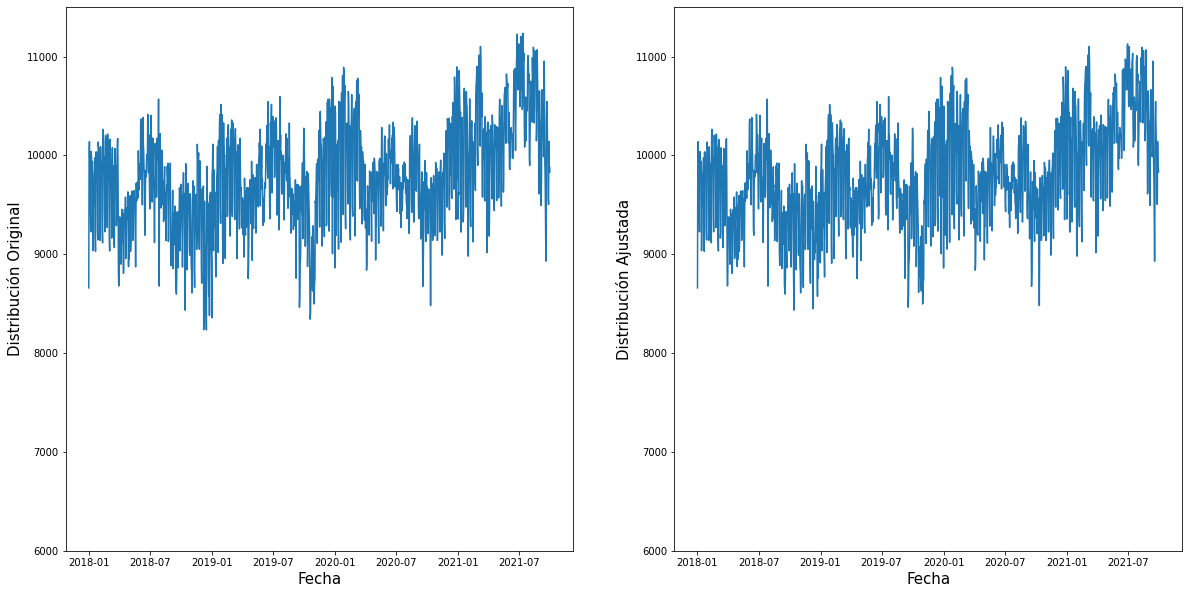

In [ ]:
# Hacemos una comparación de los datos antes (izquierda) y despues del ajuste intercuartil (derecha)
graph_new_distribution(sen_dmax_ajust, data_sen,'dmax')

### Train y Test

LOS DATOS SERÁN SEPARADOS EN LAS SIGUIENTES FECHAS PARA TRAIN Y TEST 
1.   **Datos de entrenamiento (train) o aprendizaje del modelo: 2018/01/01 - 2021/07/31**   

2.   **Datos de prueba (test) que el módelo no conoce: 2021/08/01 - 2021/09/30** 

In [ ]:
# Seleccionamos el rango de fecha en el que miraremos hacia atras para predecir
end_train_sen = '2021-08'
start_test_sen = '2021-09'

# Separando los datos de SEN
sen_train_dmin, sen_test_dmin = sen_dmin_ajust.loc[:end_train_sen], sen_dmin_ajust.loc[start_test_sen:]
sen_train_dmax, sen_test_dmax = sen_dmax_ajust.loc[:end_train_sen], sen_dmax_ajust.loc[start_test_sen:]

#################### OBTENIENDO MÁS INTERVALOS DE PRUEBA (TEST) #####################################################

# PARA SEN DMIN
#sen_test_dmin_aug = sen_dmin_ajust.loc['2021-07':'2021-08']   # Agosto
sen_test_dmin_as = sen_dmin_ajust.loc['2021-08':]             # Agosto y septiembre
# PARA SEN DMAX
#sen_test_dmax_aug = sen_dmax_ajust.loc['2021-07':'2021-08']
sen_test_dmax_as = sen_dmax_ajust.loc['2021-08':]
##############################################################################################################

print(f'SEN\nDatos Train: {sen_train_dmin.shape}\nDatos Test: {sen_test_dmin.shape}')

SEN
Datos Train: (1339, 1)
Datos Test: (30, 1)


**APRENDIZAJE SUPERVISADO**   
Antes de comenzar, es necesario recalcar que transformaremos nuestra serie temporal y la convertiremos en un “problema de tipo supervisado” para poder alimentar nuestra red neuronal y poder entrenarla con **backpropagation** (“como es habitual”).   
En el **Aprendizaje Supervisado** los datos para el entrenamiento incluyen la solución deseada, llamada “etiquetas” (labels).   
Para esto, tomaremos un rango de fechas hacia atrás (secuencia de días hacia atrás), rango escogido de 30 días que permitirá predecir el siguiente día y así sucesivamente. Expresándose de la siguiente forma:   
$(t-n), (t-(n-1)), ... , (t-3), (t-2), (t-1), (t)$   
Donde los datos de $t-n$ hasta $t-1$ serán los datos que "miraremos hacia atrás" (30 días) y $t$ sera el día a predecir.


**NORMALIZACIÓN**   
La normalización es una técnica que a menudo se aplica como parte de la preparación de datos para el aprendizaje automático. El objetivo de la normalización es cambiar los valores de las columnas numéricas en el conjunto de datos para usar una escala común, sin distorsionar las diferencias en los rangos de valores ni perder información.   
La normalización también es necesaria para que algunos algoritmos modelen los datos correctamente.   
--> Por ejemplo, suponga que su conjunto de datos de entrada contiene una columna con valores que van de 0 a 1 y otra columna con valores que van de 10,000 a 100,000. La gran diferencia en la escala de los números podría causar problemas al intentar combinar los valores como características durante el modelado.   
El rango escogido para este estudio fue de 0 a 1 . Considerando tambien que el principal objetivo es ayudar que nuestro modelo sea mas eficiente y no le cueste tanto trabajo realizar todos los cálculos en el proceso de entrenamiento.

## Datos de entrenamiento (train)

Normalizamos los datos y los transformamos en un problema de tipo supervisado con la función **normalize_and_supervised()**. Es decir, los convertimos a numeros entre 0 y 1 sin perder su proporción en cuanto a su distribución, y transformamos el dataframe para que contenga filas de secuencias y podamos entregar al modelo una entrada (un input o fila en secuencia de 30 días) y la salida real a ella, correspondiente a la etiqueta u output esperado (el día siguiente de la secuencia)

In [ ]:
transform_sen_train_dmin = normalize_and_supervised(sen_train_dmin)
transform_sen_train_dmin.shape

(1309, 31)

In [ ]:
# x_train e y_train de sen dmin
x_train_sen_dmin = transform_sen_train_dmin.iloc[:,:-1]
y_train_sen_dmin = transform_sen_train_dmin.iloc[:,-1]

In [ ]:
# Vemos las dimensiones de los datos de entrenamiento
x_train_sen_dmin.shape, y_train_sen_dmin.shape

((1309, 30), (1309,))

# Creación y entrenamiento de los modelos

## Modelo de redes neuronales Perceptrón Multicapa - MLP

In [ ]:
def model_MLP_sen():
    model = Sequential() 
    model.add(Dense(64, input_dim = x_train_sen_dmin.shape[1], activation = ACTIVATION))
    model.add(Dense(128, activation = ACTIVATION))
    model.add(Dense(PREDICTION, activation=ACTIVATION))
    
    model.compile(loss= LOSS,
              optimizer= OPTIMIZER_1,
              metrics= METRICS)

    return model

In [ ]:
model_sen_dmin_mlp = model_MLP_sen()
# Mostramos la estructura del modelo para la dmin
model_sen_dmin_mlp.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1984      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 10,433
Trainable params: 10,433
Non-trainable params: 0
_________________________________________________________________


**ENTRENANDO EL MODELO**

### Visualizando el entrenamiento

In [ ]:
# Entrenamos el modelo de dmin 
history_sen_dmin_mlp = model_sen_dmin_mlp.fit(x_train_sen_dmin, y_train_sen_dmin,
                  epochs=EPOCHS_1,
                  batch_size = BATCH_SIZE,
                  validation_split=0.1,
                  shuffle= False,
                  verbose = 2)


Train on 1178 samples, validate on 131 samples
Epoch 1/40
1178/1178 - 1s - loss: 0.0312 - mae: 0.1416 - val_loss: 0.0107 - val_mae: 0.0850
Epoch 2/40
1178/1178 - 0s - loss: 0.0185 - mae: 0.1067 - val_loss: 0.0072 - val_mae: 0.0695
Epoch 3/40
1178/1178 - 0s - loss: 0.0144 - mae: 0.0937 - val_loss: 0.0060 - val_mae: 0.0638
Epoch 4/40
1178/1178 - 0s - loss: 0.0130 - mae: 0.0881 - val_loss: 0.0055 - val_mae: 0.0607
Epoch 5/40
1178/1178 - 0s - loss: 0.0122 - mae: 0.0851 - val_loss: 0.0052 - val_mae: 0.0578
Epoch 6/40
1178/1178 - 0s - loss: 0.0118 - mae: 0.0834 - val_loss: 0.0050 - val_mae: 0.0565
Epoch 7/40
1178/1178 - 0s - loss: 0.0114 - mae: 0.0820 - val_loss: 0.0049 - val_mae: 0.0554
Epoch 8/40
1178/1178 - 0s - loss: 0.0111 - mae: 0.0810 - val_loss: 0.0048 - val_mae: 0.0549
Epoch 9/40
1178/1178 - 0s - loss: 0.0109 - mae: 0.0801 - val_loss: 0.0048 - val_mae: 0.0541
Epoch 10/40
1178/1178 - 0s - loss: 0.0107 - mae: 0.0793 - val_loss: 0.0047 - val_mae: 0.0538
Epoch 11/40
1178/1178 - 0s - los

VIENDO EL ENTRENAMIENTO DEL MODELO PARA LA DEMANDA MÍNIMA

In [ ]:
hist_sen_dmin_mlp = pd.DataFrame(history_sen_dmin_mlp.history) 
hist_sen_dmin_mlp['epoch'] = history_sen_dmin_mlp.epoch
# Mostramos las últimas 5 filas del total de epoch de entrenamiento
hist_sen_dmin_mlp.tail()

,loss,mae,val_loss,val_mae,epoch
35,0.008425,0.068843,0.004410,0.052706,35
36,0.008375,0.068687,0.004404,0.052606,36
37,0.008310,0.068387,0.004393,0.052579,37
38,0.008290,0.068292,0.004410,0.052556,38
39,0.008221,0.067983,0.004424,0.052720,39


Veremos como evolucionan estos valores durante el entrenamiento

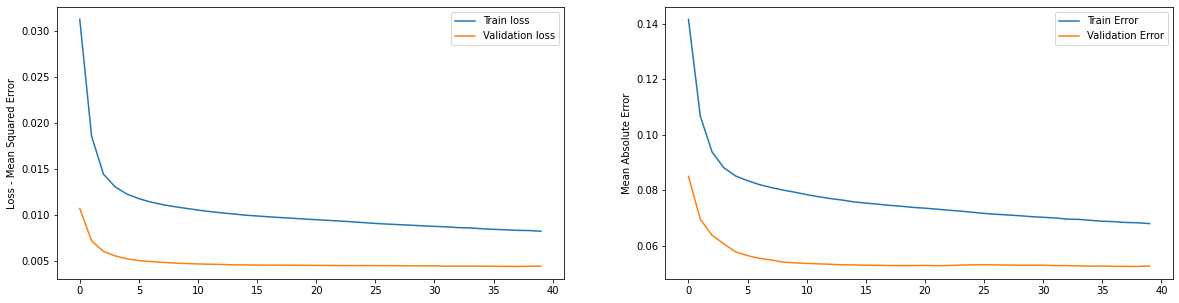

In [ ]:
plot_history(history_sen_dmin_mlp)

## Modelo de redes neuronales recurrentes (RNN) - LSTM

In [ ]:
# Redimensionando los datos de x_train para el modelo LSTM
x_train_sen_dmin = x_train_sen_dmin.values.reshape((x_train_sen_dmin.shape[0], x_train_sen_dmin.shape[1],1))

In [ ]:
x_train_sen_dmin.shape, y_train_sen_dmin.shape

((1309, 30, 1), (1309,))

In [ ]:
def model_LSTM_sen():
    model = Sequential() 
    model.add(LSTM(60, input_shape = (x_train_sen_dmin.shape[1],x_train_sen_dmin.shape[2]), return_sequences=True))
    model.add(LSTM(60, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(PREDICTION))
    
    model.compile(loss= LOSS,
              optimizer= OPTIMIZER_1,
              metrics= METRICS)

    return model

In [ ]:
model_sen_dmin_lstm = model_LSTM_sen()
# Mostramos la estructura del modelo para la dmin
model_sen_dmin_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 60)            14880     
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 60)            29040     
_________________________________________________________________
flatten (Flatten)            (None, 1800)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1801      
Total params: 45,721
Trainable params: 45,721
Non-trainable params: 0
_________________________________________________________________


**ENTRENANDO EL MODELO**

In [ ]:
# Entrenamos el modelo de dmin 
history_sen_dmin_lstm = model_sen_dmin_lstm.fit(x_train_sen_dmin, y_train_sen_dmin,
                  epochs= 70,
                  batch_size = BATCH_SIZE,
                  validation_split = 0.1,
                  shuffle= False,
                  verbose = 2)


Train on 1178 samples, validate on 131 samples
Epoch 1/70
1178/1178 - 5s - loss: 0.0548 - mae: 0.1835 - val_loss: 0.0205 - val_mae: 0.1082
Epoch 2/70
1178/1178 - 1s - loss: 0.0307 - mae: 0.1408 - val_loss: 0.0143 - val_mae: 0.1015
Epoch 3/70
1178/1178 - 1s - loss: 0.0275 - mae: 0.1336 - val_loss: 0.0133 - val_mae: 0.0966
Epoch 4/70
1178/1178 - 1s - loss: 0.0261 - mae: 0.1303 - val_loss: 0.0131 - val_mae: 0.0957
Epoch 5/70
1178/1178 - 1s - loss: 0.0257 - mae: 0.1293 - val_loss: 0.0129 - val_mae: 0.0947
Epoch 6/70
1178/1178 - 1s - loss: 0.0253 - mae: 0.1283 - val_loss: 0.0127 - val_mae: 0.0940
Epoch 7/70
1178/1178 - 1s - loss: 0.0250 - mae: 0.1275 - val_loss: 0.0126 - val_mae: 0.0933
Epoch 8/70
1178/1178 - 1s - loss: 0.0247 - mae: 0.1267 - val_loss: 0.0124 - val_mae: 0.0927
Epoch 9/70
1178/1178 - 1s - loss: 0.0244 - mae: 0.1259 - val_loss: 0.0123 - val_mae: 0.0921
Epoch 10/70
1178/1178 - 1s - loss: 0.0241 - mae: 0.1250 - val_loss: 0.0122 - val_mae: 0.0915
Epoch 11/70
1178/1178 - 1s - los

### Visualizando el entrenamiento

VIENDO EL ENTRENAMIENTO DEL MODELO PARA LA DEMANDA MÍNIMA

In [ ]:
hist_sen_dmin_lstm = pd.DataFrame(history_sen_dmin_lstm.history) 
hist_sen_dmin_lstm['epoch'] = history_sen_dmin_lstm.epoch
# Mostramos las ultimas 5 filas del total de epoch de entrenamiento
hist_sen_dmin_lstm.tail()

,loss,mae,val_loss,val_mae,epoch
65,0.011370,0.081081,0.004911,0.053877,65
66,0.011321,0.080885,0.004892,0.053783,66
67,0.011273,0.080692,0.004873,0.053686,67
68,0.011227,0.080503,0.004855,0.053586,68
69,0.011183,0.080319,0.004837,0.053482,69


Veremos como evolucionan estos valores durante el entrenamiento

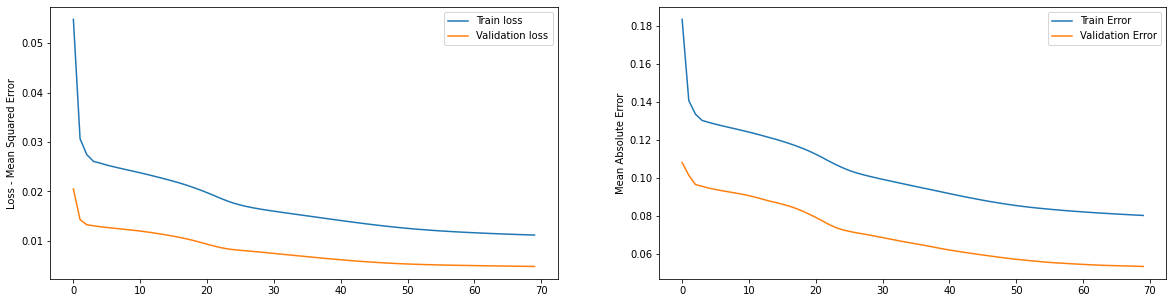

In [ ]:
plot_history(history_sen_dmin_lstm)

## Modelo de redes neuronales recurrentes (RNN) - GRU

In [ ]:
x_train_sen_dmin.shape, y_train_sen_dmin.shape

((1309, 30, 1), (1309,))

In [ ]:
def model_GRU():
    model = Sequential() 
    model.add(GRU(64, input_shape = (x_train_sen_dmin.shape[1],x_train_sen_dmin.shape[2]), return_sequences=True))
    model.add(GRU(64, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(PREDICTION))
    
    model.compile(loss= LOSS,
              optimizer= OPTIMIZER_1,
              metrics= METRICS)

    return model

In [ ]:
model_sen_dmin_gru = model_GRU()
# Mostramos la estructura del modelo para la dmin
model_sen_dmin_gru.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 30, 64)            12864     
_________________________________________________________________
gru_1 (GRU)                  (None, 30, 64)            24960     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1921      
Total params: 39,745
Trainable params: 39,745
Non-trainable params: 0
_________________________________________________________________


**ENTRENANDO EL MODELO**

In [ ]:
# Entrenamos el modelo de dmin 
history_sen_dmin_gru = model_sen_dmin_gru.fit(x_train_sen_dmin, y_train_sen_dmin,
                  epochs = 60,
                  batch_size = BATCH_SIZE,
                  validation_split = 0.1,
                  shuffle= False,
                  verbose = 2)


Train on 1178 samples, validate on 131 samples
Epoch 1/60
1178/1178 - 4s - loss: 0.0453 - mae: 0.1679 - val_loss: 0.0124 - val_mae: 0.0879
Epoch 2/60
1178/1178 - 1s - loss: 0.0233 - mae: 0.1243 - val_loss: 0.0124 - val_mae: 0.0856
Epoch 3/60
1178/1178 - 1s - loss: 0.0226 - mae: 0.1204 - val_loss: 0.0123 - val_mae: 0.0850
Epoch 4/60
1178/1178 - 1s - loss: 0.0220 - mae: 0.1184 - val_loss: 0.0090 - val_mae: 0.0760
Epoch 5/60
1178/1178 - 1s - loss: 0.0197 - mae: 0.1118 - val_loss: 0.0075 - val_mae: 0.0706
Epoch 6/60
1178/1178 - 1s - loss: 0.0173 - mae: 0.1040 - val_loss: 0.0070 - val_mae: 0.0677
Epoch 7/60
1178/1178 - 1s - loss: 0.0162 - mae: 0.0998 - val_loss: 0.0066 - val_mae: 0.0656
Epoch 8/60
1178/1178 - 1s - loss: 0.0154 - mae: 0.0970 - val_loss: 0.0062 - val_mae: 0.0636
Epoch 9/60
1178/1178 - 1s - loss: 0.0147 - mae: 0.0941 - val_loss: 0.0058 - val_mae: 0.0616
Epoch 10/60
1178/1178 - 1s - loss: 0.0140 - mae: 0.0913 - val_loss: 0.0055 - val_mae: 0.0599
Epoch 11/60
1178/1178 - 1s - los

### Visualizando el entrenamiento

VIENDO EL ENTRENAMIENTO DEL MODELO PARA LA DEMANDA MÍNIMA

In [ ]:
hist_sen_dmin_gru = pd.DataFrame(history_sen_dmin_gru.history) 
hist_sen_dmin_gru['epoch'] = history_sen_dmin_gru.epoch
# Mostramos las ultimas 5 filas del total de epoch de entrenamiento
hist_sen_dmin_gru.tail()

,loss,mae,val_loss,val_mae,epoch
55,0.009771,0.073617,0.004197,0.050545,55
56,0.009765,0.073583,0.004195,0.050532,56
57,0.009759,0.073551,0.004193,0.050519,57
58,0.009753,0.073522,0.004192,0.050506,58
59,0.009748,0.073492,0.004190,0.050494,59


Veremos como evolucionan estos valores durante el entrenamiento

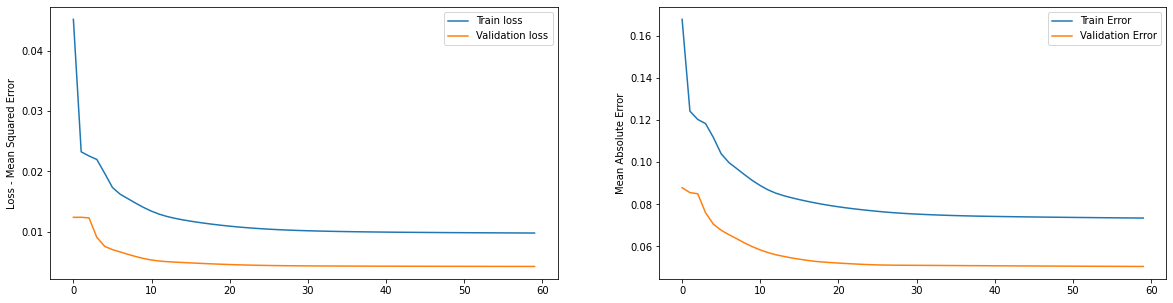

In [ ]:
plot_history(history_sen_dmin_gru)

## Modelo Hibrido 1 - Conv1D, LSTM y Dense

In [ ]:
x_train_sen_dmin.shape, y_train_sen_dmin.shape

((1309, 30, 1), (1309,))

In [ ]:
def model_hibrido():
    model = Sequential() 
    model.add(Conv1D(32,11, input_shape = (x_train_sen_dmin.shape[1],x_train_sen_dmin.shape[2]),activation='relu',padding='same'))
    model.add(MaxPool1D())
    model.add(Conv1D(32,11, activation=ACTIVATION, padding='same'))
    model.add(MaxPool1D())
    model.add(LSTM(32, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(PREDICTION))
    
    model.compile(loss= LOSS,
              optimizer= OPTIMIZER_1,
              metrics= METRICS)

    return model

In [ ]:
model_sen_dmin_hibrido = model_hibrido()
# Mostramos la estructura del modelo para la dmin
model_sen_dmin_hibrido.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 30, 32)            384       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 15, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 15, 32)            11296     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 32)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 7, 32)             8320      
_________________________________________________________________
flatten_2 (Flatten)          (None, 224)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

**ENTRENANDO EL MODELO**

In [ ]:
# Entrenamos el modelo de dmax
history_sen_dmin_hibrido = model_sen_dmin_hibrido.fit(x_train_sen_dmin, y_train_sen_dmin,
                  epochs= 50,
                  batch_size = BATCH_SIZE,
                  validation_split = 0.1,
                  shuffle= False,
                  verbose = 2)


Train on 1178 samples, validate on 131 samples
Epoch 1/50
1178/1178 - 3s - loss: 0.0530 - mae: 0.1815 - val_loss: 0.0142 - val_mae: 0.1010
Epoch 2/50
1178/1178 - 0s - loss: 0.0271 - mae: 0.1329 - val_loss: 0.0149 - val_mae: 0.1046
Epoch 3/50
1178/1178 - 0s - loss: 0.0238 - mae: 0.1242 - val_loss: 0.0123 - val_mae: 0.0944
Epoch 4/50
1178/1178 - 0s - loss: 0.0210 - mae: 0.1164 - val_loss: 0.0101 - val_mae: 0.0845
Epoch 5/50
1178/1178 - 0s - loss: 0.0188 - mae: 0.1092 - val_loss: 0.0077 - val_mae: 0.0724
Epoch 6/50
1178/1178 - 0s - loss: 0.0167 - mae: 0.1022 - val_loss: 0.0060 - val_mae: 0.0635
Epoch 7/50
1178/1178 - 0s - loss: 0.0153 - mae: 0.0967 - val_loss: 0.0054 - val_mae: 0.0601
Epoch 8/50
1178/1178 - 0s - loss: 0.0140 - mae: 0.0917 - val_loss: 0.0052 - val_mae: 0.0583
Epoch 9/50
1178/1178 - 0s - loss: 0.0130 - mae: 0.0874 - val_loss: 0.0049 - val_mae: 0.0562
Epoch 10/50
1178/1178 - 0s - loss: 0.0122 - mae: 0.0842 - val_loss: 0.0047 - val_mae: 0.0547
Epoch 11/50
1178/1178 - 0s - los

### Visualizando el entrenamiento

VIENDO EL ENTRENAMIENTO DEL MODELO PARA LA DEMANDA MÁXIMA

In [ ]:
hist_sen_dmin_hibrido = pd.DataFrame(history_sen_dmin_hibrido.history) 
hist_sen_dmin_hibrido['epoch'] = history_sen_dmin_hibrido.epoch
# Mostramos las ultimas 5 filas del total de epoch de entrenamiento
hist_sen_dmin_hibrido.tail()

,loss,mae,val_loss,val_mae,epoch
45,0.007908,0.065746,0.004271,0.051225,45
46,0.007867,0.065560,0.004279,0.051269,46
47,0.007843,0.065503,0.004276,0.051255,47
48,0.007824,0.065408,0.004291,0.051272,48
49,0.007789,0.065244,0.004294,0.051386,49


Veremos como evolucionan estos valores durante el entrenamiento

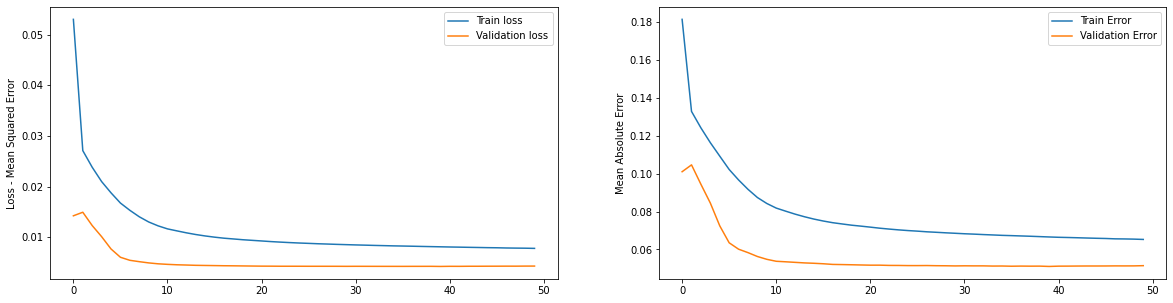

In [ ]:
plot_history(history_sen_dmin_hibrido)

## Modelo Hibrido 2 - Conv1D, GRU y Dense

In [ ]:
x_train_sen_dmin.shape, y_train_sen_dmin.shape

((1309, 30, 1), (1309,))

In [ ]:
def model_hibrido2():
    model = Sequential() 
    model.add(Conv1D(32,9, input_shape = (x_train_sen_dmin.shape[1],x_train_sen_dmin.shape[2]),activation='relu',padding='same'))
    model.add(MaxPool1D())
    model.add(Conv1D(32,9, activation=ACTIVATION, padding='same'))
    model.add(MaxPool1D())
    model.add(GRU(64, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(PREDICTION))
    
    model.compile(loss= LOSS,
              optimizer= OPTIMIZER_1,
              metrics= METRICS)

    return model

In [ ]:
model_sen_dmin_hibrido2 = model_hibrido2()
# Mostramos la estructura del modelo para la dmin
model_sen_dmin_hibrido2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 30, 32)            320       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 15, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 15, 32)            9248      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 7, 32)             0         
_________________________________________________________________
gru_2 (GRU)                  (None, 7, 64)             18816     
_________________________________________________________________
flatten_3 (Flatten)          (None, 448)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

**ENTRENANDO EL MODELO**

In [ ]:
# Entrenamos el modelo de dmax
history_sen_dmin_hibrido2 = model_sen_dmin_hibrido2.fit(x_train_sen_dmin, y_train_sen_dmin,
                  epochs= 50,
                  batch_size = BATCH_SIZE,
                  validation_split = 0.1,
                  shuffle= False,
                  verbose = 2)


Train on 1178 samples, validate on 131 samples
Epoch 1/50
1178/1178 - 4s - loss: 0.0482 - mae: 0.1753 - val_loss: 0.0131 - val_mae: 0.0953
Epoch 2/50
1178/1178 - 1s - loss: 0.0282 - mae: 0.1359 - val_loss: 0.0136 - val_mae: 0.0991
Epoch 3/50
1178/1178 - 0s - loss: 0.0230 - mae: 0.1222 - val_loss: 0.0108 - val_mae: 0.0870
Epoch 4/50
1178/1178 - 0s - loss: 0.0205 - mae: 0.1147 - val_loss: 0.0082 - val_mae: 0.0749
Epoch 5/50
1178/1178 - 0s - loss: 0.0177 - mae: 0.1055 - val_loss: 0.0060 - val_mae: 0.0638
Epoch 6/50
1178/1178 - 0s - loss: 0.0157 - mae: 0.0981 - val_loss: 0.0055 - val_mae: 0.0600
Epoch 7/50
1178/1178 - 0s - loss: 0.0140 - mae: 0.0918 - val_loss: 0.0053 - val_mae: 0.0592
Epoch 8/50
1178/1178 - 0s - loss: 0.0126 - mae: 0.0857 - val_loss: 0.0050 - val_mae: 0.0568
Epoch 9/50
1178/1178 - 0s - loss: 0.0118 - mae: 0.0824 - val_loss: 0.0048 - val_mae: 0.0554
Epoch 10/50
1178/1178 - 0s - loss: 0.0112 - mae: 0.0799 - val_loss: 0.0047 - val_mae: 0.0547
Epoch 11/50
1178/1178 - 0s - los

### Visualizando el entrenamiento

VIENDO EL ENTRENAMIENTO DEL MODELO PARA LA DEMANDA MÁXIMA

In [ ]:
hist_sen_dmin_hibrido2 = pd.DataFrame(history_sen_dmin_hibrido2.history) 
hist_sen_dmin_hibrido2['epoch'] = history_sen_dmin_hibrido2.epoch
# Mostramos las ultimas 5 filas del total de epoch de entrenamiento
hist_sen_dmin_hibrido2.tail()

,loss,mae,val_loss,val_mae,epoch
45,0.007628,0.064448,0.004861,0.053967,45
46,0.007578,0.064223,0.004855,0.053935,46
47,0.007536,0.064043,0.004868,0.053925,47
48,0.007478,0.063760,0.004886,0.053999,48
49,0.007438,0.063648,0.004914,0.054033,49


Veremos como evolucionan estos valores durante el entrenamiento

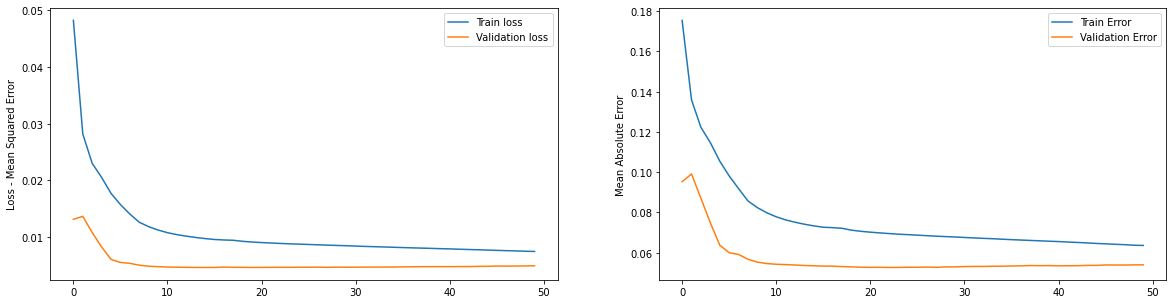

In [ ]:
plot_history(history_sen_dmin_hibrido2)

# Predicciones en el tiempo

In [ ]:
sen_test_dmin_as

,dmin
fecha,
2021-08-01,7711.62
2021-08-02,7722.29
2021-08-03,8055.33
2021-08-04,8074.22
2021-08-05,8097.39
...,...
2021-09-26,7634.18
2021-09-27,7811.68
2021-09-28,8050.98


In [ ]:
test_supervised = series_to_supervised(sen_test_dmin_as,30,1)
test_supervised.head()

,var1(t-30),var1(t-29),var1(t-28),var1(t-27),var1(t-26),var1(t-25),var1(t-24),var1(t-23),var1(t-22),var1(t-21),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
fecha,,,,,,,,,,,,,,,,,,,,,
2021-08-31,7711.62,7722.29,8055.33,8074.22,8097.39,8240.47,8191.95,7826.94,8069.62,8216.51,...,7592.87,7925.54,8010.83,7931.54,7988.20,7893.09,7934.24,7534.51,7608.88,8077.46
2021-09-01,7722.29,8055.33,8074.22,8097.39,8240.47,8191.95,7826.94,8069.62,8216.51,8231.93,...,7925.54,8010.83,7931.54,7988.20,7893.09,7934.24,7534.51,7608.88,8077.46,7949.00
2021-09-02,8055.33,8074.22,8097.39,8240.47,8191.95,7826.94,8069.62,8216.51,8231.93,8145.59,...,8010.83,7931.54,7988.20,7893.09,7934.24,7534.51,7608.88,8077.46,7949.00,7883.80
2021-09-03,8074.22,8097.39,8240.47,8191.95,7826.94,8069.62,8216.51,8231.93,8145.59,8308.40,...,7931.54,7988.20,7893.09,7934.24,7534.51,7608.88,8077.46,7949.00,7883.80,7725.30
2021-09-04,8097.39,8240.47,8191.95,7826.94,8069.62,8216.51,8231.93,8145.59,8308.40,8260.39,...,7988.20,7893.09,7934.24,7534.51,7608.88,8077.46,7949.00,7883.80,7725.30,7837.16


In [ ]:
vector_test = test_supervised.iloc[1]

In [ ]:
vector_test.shape

(31,)

In [ ]:
# Vamos a separar este vector en 2, los primeros 30 para que el modelo prediga y el día 31 para evaluar la predicción
vector_input_test = vector_test.iloc[:-1]
vector_output_test = vector_test.iloc[30]
print(f'Entrada test: {vector_input_test.shape}')
print(f'Salida test : {vector_output_test.shape}')

Entrada test: (30,)
Salida test : ()


Ahora debemos hacer 2 cosas...   
- Primero normalizar los datos a una escala de 0 a 1.   
- Segundo modificar las dimensiones de los datos para ser aceptados por los modelos. 


In [ ]:
# Normalizando los datos
# El input
vector_input_test = np.array(vector_input_test).reshape(-1,1) # transformamos a array y redimensionamos a (-1,1)
norm_input_test = SCALER.transform(vector_input_test) # normalizamos los datos
# El output
vector_output_test = np.array(vector_output_test).reshape(-1,1)
norm_output_test = SCALER.transform(vector_output_test)
print(f'Vemos las dimensiones de los datos ya normalizados')
print(f'Input: {norm_input_test.shape}\nOutput: {norm_output_test.shape}')

Vemos las dimensiones de los datos ya normalizados
Input: (30, 1)
Output: (1, 1)


In [ ]:
# Modificar las dimensiones
norm_input_test = norm_input_test.reshape((1,30))

In [ ]:
norm_input_test.shape

(1, 30)

In [ ]:
def new_predicts(prediction,x_test):
  new_predict = np.append(x_test,prediction)
  new_predict = new_predict[PREDICTION:]
  new_predict = new_predict.reshape((1,30))
  
  return new_predict

def prediction(x_test, model, n_predicts = 1):

  results = []
  while n_predicts > 0:
    prediction = model.predict(x_test)
    results = np.append(results, prediction)
    x_test = new_predicts(prediction, x_test)
    n_predicts -=1
  results = results.reshape(-1,1)
  return results

In [ ]:
PREDICT_1_WEEK = 7
PREDICT_2_WEEK = 14
PREDICT_3_WEEK = 21
PREDICT_4_WEEK = 28

index_1_semana = sen_test_dmin_as.loc['2021-09-01':'2021-09-07'].index
index_2_semana = sen_test_dmin_as.loc['2021-09-01':'2021-09-14'].index
index_3_semana = sen_test_dmin_as.loc['2021-09-01':'2021-09-21'].index
index_4_semana = sen_test_dmin_as.loc['2021-09-01':'2021-09-28'].index

In [ ]:
semana_1 = np.array(sen_test_dmin_as.loc['2021-09-01':'2021-09-07']).reshape(-1,1)
semana_2 = np.array(sen_test_dmin_as.loc['2021-09-01':'2021-09-14']).reshape(-1,1)
semana_3 = np.array(sen_test_dmin_as.loc['2021-09-01':'2021-09-21']).reshape(-1,1)
semana_4 = np.array(sen_test_dmin_as.loc['2021-09-01':'2021-09-28']).reshape(-1,1)

## MLP

**PROBANDO PREDECIR 1 SEMANA**

In [ ]:
mlp_1_semana_norm = prediction(norm_input_test, model_sen_dmin_mlp, PREDICT_1_WEEK)

In [ ]:
mlp_1_semana= SCALER.inverse_transform(mlp_1_semana_norm)

In [ ]:
results_mlp_1 = {
    'MSE': round(float(mean_squared_error(semana_1, mlp_1_semana)),6),
    'MAE': round(float(mean_absolute_error(semana_1, mlp_1_semana)),6),
    'MAPE': round(float(mape(semana_1, mlp_1_semana)),6)
    }
results_mlp_1

{'MAE': 135.186614, 'MAPE': 1.760662, 'MSE': 25292.074176}

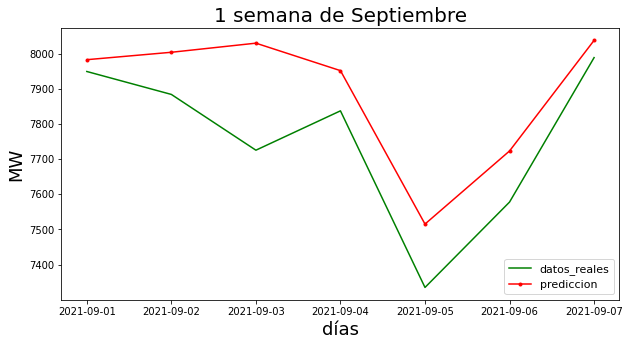

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(index_1_semana, semana_1, c='g', label = 'datos_reales')
plt.plot(index_1_semana, mlp_1_semana, '.-r', label = 'prediccion')
plt.title('1 semana de Septiembre', fontsize = 20)
plt.xlabel('días', fontsize = 18)
plt.ylabel('MW', fontsize = 18)
plt.legend(loc = 'lower right', fontsize = 11)
plt.show()

**Probando predecir 2 semanas**

In [ ]:
mlp_2_semana_norm = prediction(norm_input_test, model_sen_dmin_mlp, PREDICT_2_WEEK)

In [ ]:
mlp_2_semana= SCALER.inverse_transform(mlp_2_semana_norm)

In [ ]:
results_mlp_2 = {
    'MSE': round(float(mean_squared_error(semana_2, mlp_2_semana)),6),
    'MAE': round(float(mean_absolute_error(semana_2, mlp_2_semana)),6),
    'MAPE': round(float(mape(semana_2, mlp_2_semana)),6)
    }
results_mlp_2

{'MAE': 144.303746, 'MAPE': 1.836705, 'MSE': 27438.496035}

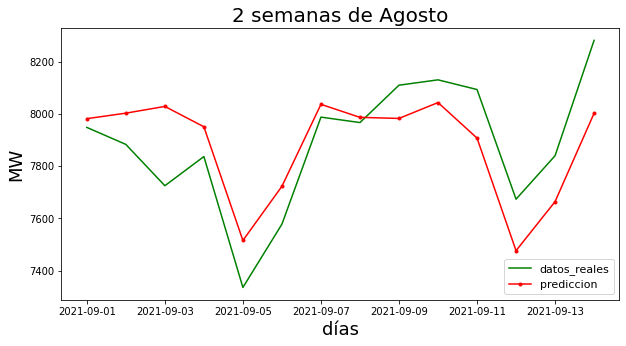

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(index_2_semana, semana_2, c='g', label = 'datos_reales')
plt.plot(index_2_semana, mlp_2_semana, '.-r', label = 'prediccion')
plt.title('2 semanas de Agosto', fontsize = 20)
plt.xlabel('días', fontsize = 18)
plt.ylabel('MW', fontsize = 18)
plt.legend(loc = 'lower right', fontsize = 11)
plt.show()

**Probando predecir 3 semanas**

In [ ]:
mlp_3_semana_norm = prediction(norm_input_test, model_sen_dmin_mlp, PREDICT_3_WEEK)

In [ ]:
mlp_3_semana= SCALER.inverse_transform(mlp_3_semana_norm)

In [ ]:
results_mlp_3 = {
    'MSE': round(float(mean_squared_error(semana_3, mlp_3_semana)),6),
    'MAE': round(float(mean_absolute_error(semana_3, mlp_3_semana)),6),
    'MAPE': round(float(mape(semana_3, mlp_3_semana)),6)
    }
results_mlp_3

{'MAE': 164.140478, 'MAPE': 2.125605, 'MSE': 42956.699954}

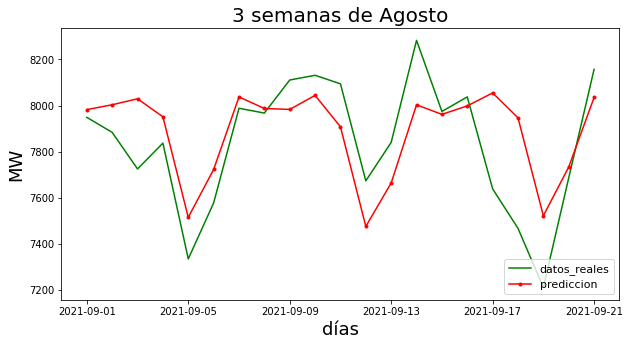

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(index_3_semana, semana_3, c='g', label = 'datos_reales')
plt.plot(index_3_semana, mlp_3_semana, '.-r', label = 'prediccion')
plt.title('3 semanas de Agosto', fontsize = 20)
plt.xlabel('días', fontsize = 18)
plt.ylabel('MW', fontsize = 18)
plt.legend(loc = 'lower right', fontsize = 11)
plt.show()

**Probando predecir 4 semanas**

In [ ]:
mlp_4_semana_norm = prediction(norm_input_test, model_sen_dmin_mlp, PREDICT_4_WEEK)

In [ ]:
mlp_4_semana= SCALER.inverse_transform(mlp_4_semana_norm)

In [ ]:
results_mlp_4 = {
    'MSE': round(float(mean_squared_error(semana_4, mlp_4_semana)),6),
    'MAE': round(float(mean_absolute_error(semana_4, mlp_4_semana)),6),
    'MAPE': round(float(mape(semana_4, mlp_4_semana)),6)
    }
results_mlp_4

{'MAE': 146.679829, 'MAPE': 1.890996, 'MSE': 35231.538769}

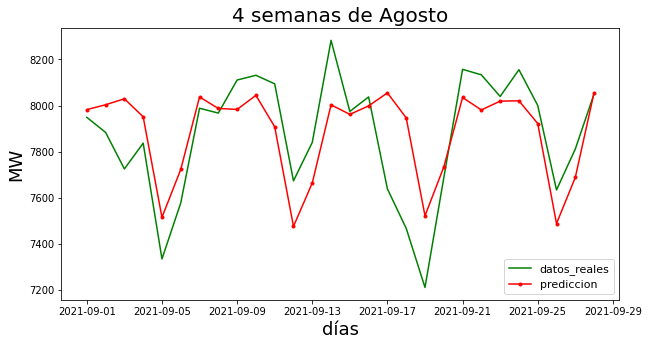

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(index_4_semana, semana_4, c='g', label = 'datos_reales')
plt.plot(index_4_semana, mlp_4_semana, '.-r', label = 'prediccion')
plt.title('4 semanas de Agosto', fontsize = 20)
plt.xlabel('días', fontsize = 18)
plt.ylabel('MW', fontsize = 18)
plt.legend(loc = 'lower right', fontsize = 11)
plt.show()

In [ ]:
def new_predict(prediction,x_test):
  new_predict = np.append(x_test,prediction)
  new_predict = new_predict[PREDICTION:]
  new_predict = new_predict.reshape((1,30,1))
  
  return new_predict

def predictions(x_test, model, n_predicts = 1):

  results = []
  while n_predicts > 0:
    prediction = model.predict(x_test)
    results = np.append(results, prediction)
    x_test = new_predict(prediction, x_test)
    n_predicts -=1
  results = results.reshape(-1,1)
  return results

## LSTM

In [ ]:
norm_input_test = norm_input_test.reshape((1,30,1))
norm_input_test.shape

(1, 30, 1)

**Probando predecir 1 semana**

In [ ]:
lstm_1_semana_norm = predictions(norm_input_test, model_sen_dmin_lstm, PREDICT_1_WEEK)

In [ ]:
lstm_1_semana= SCALER.inverse_transform(lstm_1_semana_norm)

In [ ]:
results_lstm_1 = {
    'MSE': round(float(mean_squared_error(semana_1, lstm_1_semana)),6),
    'MAE': round(float(mean_absolute_error(semana_1, lstm_1_semana)),6),
    'MAPE': round(float(mape(semana_1, lstm_1_semana)),6)
    }
results_lstm_1

{'MAE': 154.476217, 'MAPE': 2.02093, 'MSE': 37289.957883}

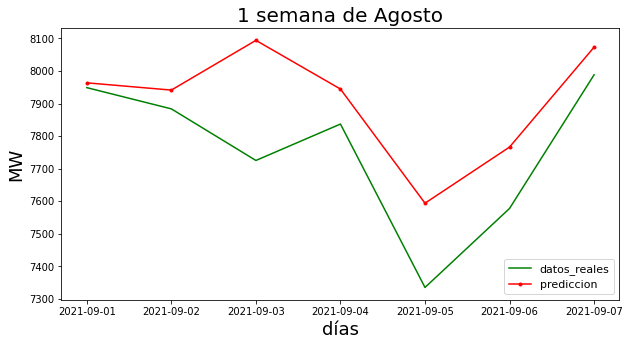

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(index_1_semana, semana_1, c='g', label = 'datos_reales')
plt.plot(index_1_semana, lstm_1_semana, '.-r', label = 'prediccion')
plt.title('1 semana de Agosto', fontsize = 20)
plt.xlabel('días', fontsize = 18)
plt.ylabel('MW', fontsize = 18)
plt.legend(loc = 'lower right', fontsize = 11)
plt.show()

**Probando predecir 2 semanas**

In [ ]:
lstm_2_semana_norm = predictions(norm_input_test, model_sen_dmin_lstm, PREDICT_2_WEEK)

In [ ]:
lstm_2_semana= SCALER.inverse_transform(lstm_2_semana_norm)

In [ ]:
results_lstm_2 = {
    'MSE': round(float(mean_squared_error(semana_2, lstm_2_semana)),6),
    'MAE': round(float(mean_absolute_error(semana_2, lstm_2_semana)),6),
    'MAPE': round(float(mape(semana_2, lstm_2_semana)),6)
    }
results_lstm_2

{'MAE': 123.931766, 'MAPE': 1.588796, 'MSE': 25427.41988}

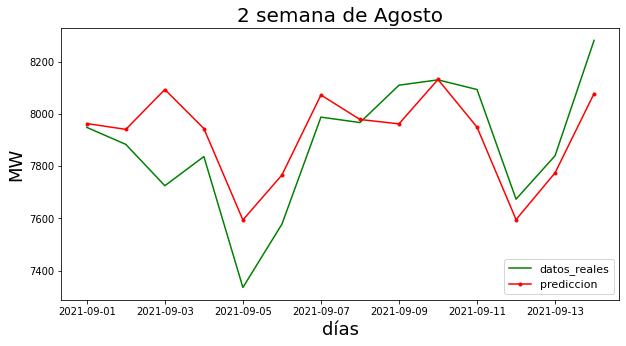

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(index_2_semana, semana_2, c='g', label = 'datos_reales')
plt.plot(index_2_semana, lstm_2_semana, '.-r', label = 'prediccion')
plt.title('2 semana de Agosto', fontsize = 20)
plt.xlabel('días', fontsize = 18)
plt.ylabel('MW', fontsize = 18)
plt.legend(loc = 'lower right', fontsize = 11)
plt.show()

**Probando predecir 3 semanas**

In [ ]:
lstm_3_semana_norm = predictions(norm_input_test, model_sen_dmin_lstm, PREDICT_3_WEEK)

In [ ]:
lstm_3_semana= SCALER.inverse_transform(lstm_3_semana_norm)

In [ ]:
results_lstm_3 = {
    'MSE': round(float(mean_squared_error(semana_3, lstm_3_semana)),6),
    'MAE': round(float(mean_absolute_error(semana_3, lstm_3_semana)),6),
    'MAPE': round(float(mape(semana_3, lstm_3_semana)),6)
    }
results_lstm_3

{'MAE': 163.337261, 'MAPE': 2.135714, 'MSE': 51943.181078}

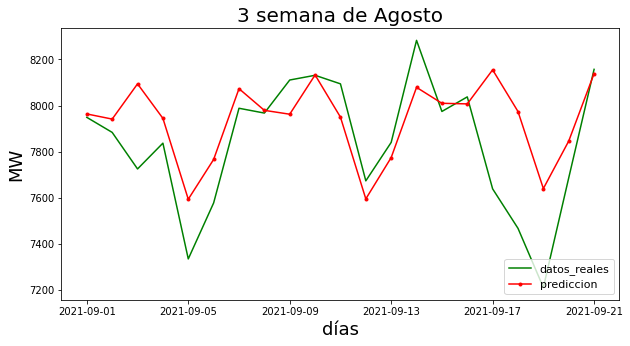

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(index_3_semana, semana_3, c='g', label = 'datos_reales')
plt.plot(index_3_semana, lstm_3_semana, '.-r', label = 'prediccion')
plt.title('3 semana de Agosto', fontsize = 20)
plt.xlabel('días', fontsize = 18)
plt.ylabel('MW', fontsize = 18)
plt.legend(loc = 'lower right', fontsize = 11)
plt.show()

**Probando predecir 4 semanas**

In [ ]:
lstm_4_semana_norm = predictions(norm_input_test, model_sen_dmin_lstm, PREDICT_4_WEEK)

In [ ]:
lstm_4_semana= SCALER.inverse_transform(lstm_4_semana_norm)

In [ ]:
results_lstm_4 = {
    'MSE': round(float(mean_squared_error(semana_4, lstm_4_semana)),6),
    'MAE': round(float(mean_absolute_error(semana_4, lstm_4_semana)),6),
    'MAPE': round(float(mape(semana_4, lstm_4_semana)),6)
    }
results_lstm_4

{'MAE': 133.672131, 'MAPE': 1.741374, 'MSE': 39831.781775}

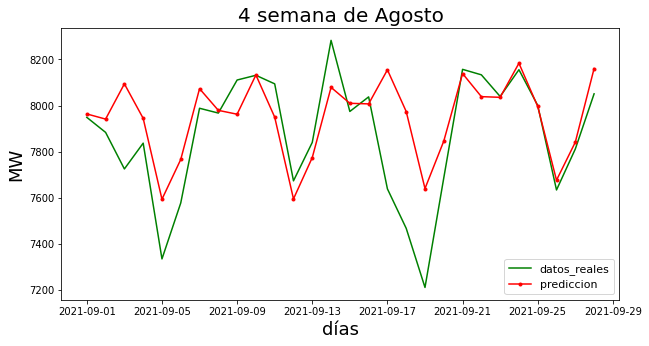

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(index_4_semana, semana_4, c='g', label = 'datos_reales')
plt.plot(index_4_semana, lstm_4_semana, '.-r', label = 'prediccion')
plt.title('4 semana de Agosto', fontsize = 20)
plt.xlabel('días', fontsize = 18)
plt.ylabel('MW', fontsize = 18)
plt.legend(loc = 'lower right', fontsize = 11)
plt.show()

## GRU

**Probando predecir 1 semana**

In [ ]:
gru_1_semana_norm = predictions(norm_input_test, model_sen_dmin_gru, PREDICT_1_WEEK)

In [ ]:
gru_1_semana= SCALER.inverse_transform(gru_1_semana_norm)

In [ ]:
results_gru_1 = {
    'MSE': round(float(mean_squared_error(semana_1, gru_1_semana)),6),
    'MAE': round(float(mean_absolute_error(semana_1, gru_1_semana)),6),
    'MAPE': round(float(mape(semana_1, gru_1_semana)),6)
    }
results_gru_1

{'MAE': 156.568169, 'MAPE': 2.047057, 'MSE': 33766.907149}

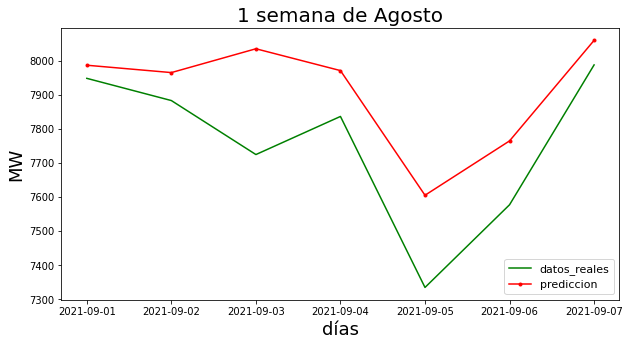

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(index_1_semana, semana_1, c='g', label = 'datos_reales')
plt.plot(index_1_semana, gru_1_semana, '.-r', label = 'prediccion')
plt.title('1 semana de Agosto', fontsize = 20)
plt.xlabel('días', fontsize = 18)
plt.ylabel('MW', fontsize = 18)
plt.legend(loc = 'lower right', fontsize = 11)
plt.show()

**Probando predecir 2 semanas**

In [ ]:
gru_2_semana_norm = predictions(norm_input_test, model_sen_dmin_gru, PREDICT_2_WEEK)

In [ ]:
gru_2_semana= SCALER.inverse_transform(gru_2_semana_norm)

In [ ]:
results_gru_2 = {
    'MSE': round(float(mean_squared_error(semana_2, gru_2_semana)),6),
    'MAE': round(float(mean_absolute_error(semana_2, gru_2_semana)),6),
    'MAPE': round(float(mape(semana_2, gru_2_semana)),6)
    }
results_gru_2

{'MAE': 124.132897, 'MAPE': 1.588884, 'MSE': 23141.232181}

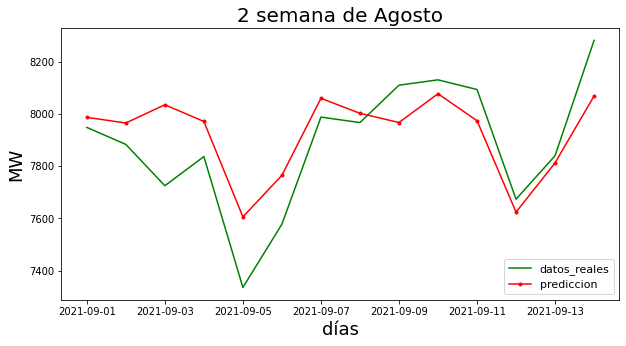

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(index_2_semana, semana_2, c='g', label = 'datos_reales')
plt.plot(index_2_semana, gru_2_semana, '.-r', label = 'prediccion')
plt.title('2 semana de Agosto', fontsize = 20)
plt.xlabel('días', fontsize = 18)
plt.ylabel('MW', fontsize = 18)
plt.legend(loc = 'lower right', fontsize = 11)
plt.show()

**Probando predecir 3 semanas**

In [ ]:
gru_3_semana_norm = predictions(norm_input_test, model_sen_dmin_gru, PREDICT_3_WEEK)

In [ ]:
gru_3_semana= SCALER.inverse_transform(gru_3_semana_norm)

In [ ]:
results_gru_3 = {
    'MSE': round(float(mean_squared_error(semana_3, gru_3_semana)),6),
    'MAE': round(float(mean_absolute_error(semana_3, gru_3_semana)),6),
    'MAPE': round(float(mape(semana_3, gru_3_semana)),6)
    }
results_gru_3

{'MAE': 167.290483, 'MAPE': 2.186333, 'MSE': 52122.803981}

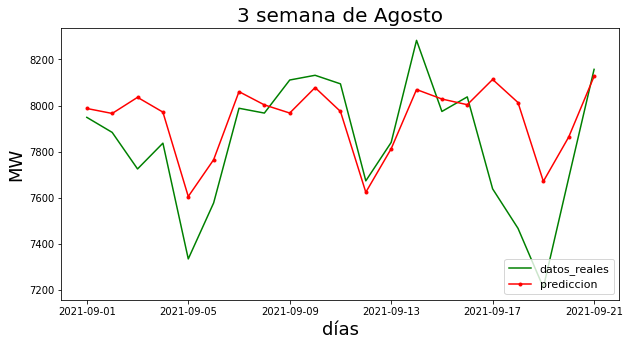

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(index_3_semana, semana_3, c='g', label = 'datos_reales')
plt.plot(index_3_semana, gru_3_semana, '.-r', label = 'prediccion')
plt.title('3 semana de Agosto', fontsize = 20)
plt.xlabel('días', fontsize = 18)
plt.ylabel('MW', fontsize = 18)
plt.legend(loc = 'lower right', fontsize = 11)
plt.show()

**Probando predecir 4 semanas**

In [ ]:
gru_4_semana_norm = predictions(norm_input_test, model_sen_dmin_gru, PREDICT_4_WEEK)

In [ ]:
gru_4_semana= SCALER.inverse_transform(gru_4_semana_norm)

In [ ]:
results_gru_4 = {
    'MSE': round(float(mean_squared_error(semana_4, gru_4_semana)),6),
    'MAE': round(float(mean_absolute_error(semana_4, gru_4_semana)),6),
    'MAPE': round(float(mape(semana_4, gru_4_semana)),6)
    }
results_gru_4

{'MAE': 138.828691, 'MAPE': 1.807679, 'MSE': 40002.052167}

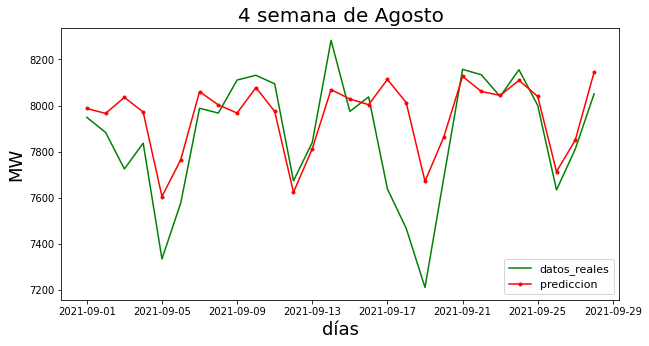

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(index_4_semana, semana_4, c='g', label = 'datos_reales')
plt.plot(index_4_semana, gru_4_semana, '.-r', label = 'prediccion')
plt.title('4 semana de Agosto', fontsize = 20)
plt.xlabel('días', fontsize = 18)
plt.ylabel('MW', fontsize = 18)
plt.legend(loc = 'lower right', fontsize = 11)
plt.show()

## HIBRIDO 1

**Probando predecir 1 semana**

In [ ]:
hibrido1_1_semana_norm = predictions(norm_input_test, model_sen_dmin_hibrido, PREDICT_1_WEEK)

In [ ]:
hibrido1_1_semana= SCALER.inverse_transform(hibrido1_1_semana_norm)

In [ ]:
results_hibrido1_1 = {
    'MSE': round(float(mean_squared_error(semana_1, hibrido1_1_semana)),6),
    'MAE': round(float(mean_absolute_error(semana_1, hibrido1_1_semana)),6),
    'MAPE': round(float(mape(semana_1, hibrido1_1_semana)),6)
    }
results_hibrido1_1

{'MAE': 108.28234, 'MAPE': 1.412981, 'MSE': 15750.88291}

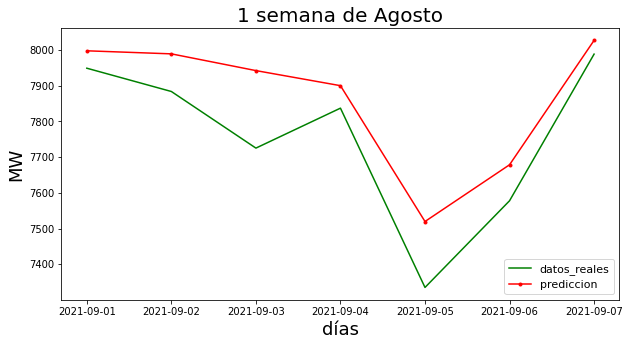

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(index_1_semana, semana_1, c='g', label = 'datos_reales')
plt.plot(index_1_semana, hibrido1_1_semana, '.-r', label = 'prediccion')
plt.title('1 semana de Agosto', fontsize = 20)
plt.xlabel('días', fontsize = 18)
plt.ylabel('MW', fontsize = 18)
plt.legend(loc = 'lower right', fontsize = 11)
plt.show()

**Probando predecir 2 semanas**

In [ ]:
hibrido1_2_semana_norm = predictions(norm_input_test, model_sen_dmin_hibrido, PREDICT_2_WEEK)

In [ ]:
hibrido1_2_semana= SCALER.inverse_transform(hibrido1_2_semana_norm)

In [ ]:
results_hibrido1_2 = {
    'MSE': round(float(mean_squared_error(semana_2, hibrido1_2_semana)),6),
    'MAE': round(float(mean_absolute_error(semana_2, hibrido1_2_semana)),6),
    'MAPE': round(float(mape(semana_2, hibrido1_2_semana)),6)
    }
results_hibrido1_2

{'MAE': 148.693071, 'MAPE': 1.8822, 'MSE': 28800.838347}

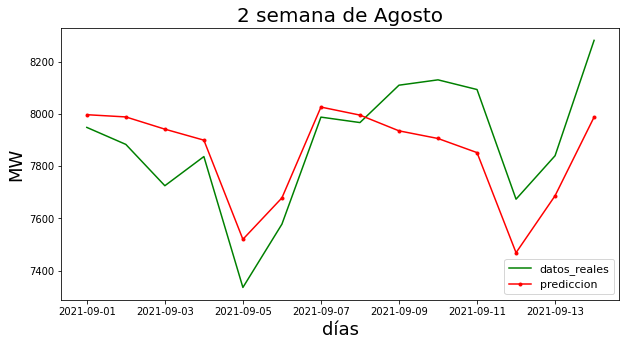

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(index_2_semana, semana_2, c='g', label = 'datos_reales')
plt.plot(index_2_semana, hibrido1_2_semana, '.-r', label = 'prediccion')
plt.title('2 semana de Agosto', fontsize = 20)
plt.xlabel('días', fontsize = 18)
plt.ylabel('MW', fontsize = 18)
plt.legend(loc = 'lower right', fontsize = 11)
plt.show()

**Probando predecir 3 semanas**

In [ ]:
hibrido1_3_semana_norm = predictions(norm_input_test, model_sen_dmin_hibrido, PREDICT_3_WEEK)

In [ ]:
hibrido1_3_semana= SCALER.inverse_transform(hibrido1_3_semana_norm)

In [ ]:
results_hibrido1_3 = {
    'MSE': round(float(mean_squared_error(semana_3, hibrido1_3_semana)),6),
    'MAE': round(float(mean_absolute_error(semana_3, hibrido1_3_semana)),6),
    'MAPE': round(float(mape(semana_3, hibrido1_3_semana)),6)
    }
results_hibrido1_3

{'MAE': 157.091882, 'MAPE': 2.020047, 'MSE': 35367.162576}

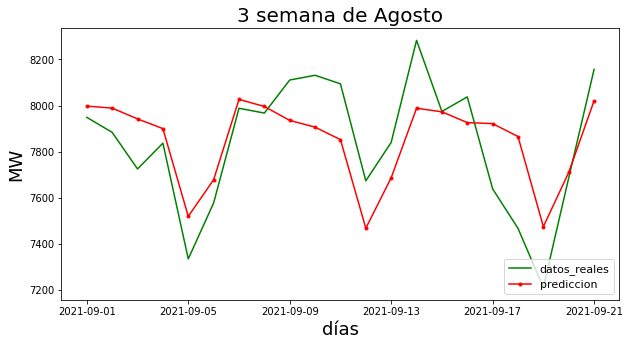

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(index_3_semana, semana_3, c='g', label = 'datos_reales')
plt.plot(index_3_semana, hibrido1_3_semana, '.-r', label = 'prediccion')
plt.title('3 semana de Agosto', fontsize = 20)
plt.xlabel('días', fontsize = 18)
plt.ylabel('MW', fontsize = 18)
plt.legend(loc = 'lower right', fontsize = 11)
plt.show()

**Probando predecir 4 semanas**

In [ ]:
hibrido1_4_semana_norm = predictions(norm_input_test, model_sen_dmin_hibrido, PREDICT_4_WEEK)

In [ ]:
hibrido1_4_semana= SCALER.inverse_transform(hibrido1_4_semana_norm)

In [ ]:
results_hibrido1_4 = {
    'MSE': round(float(mean_squared_error(semana_4, hibrido1_4_semana)),6),
    'MAE': round(float(mean_absolute_error(semana_4, hibrido1_4_semana)),6),
    'MAPE': round(float(mape(semana_4, hibrido1_4_semana)),6)
    }
results_hibrido1_4

{'MAE': 158.229273, 'MAPE': 2.022239, 'MSE': 34025.741054}

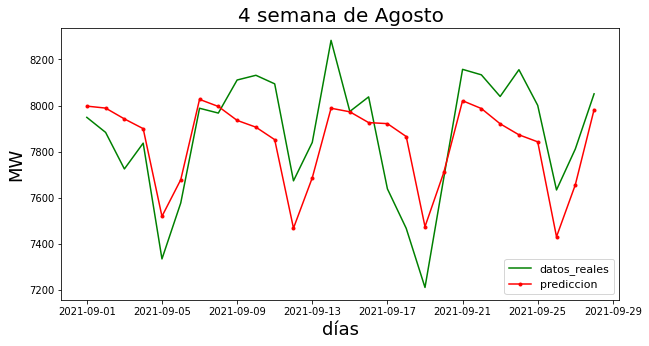

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(index_4_semana, semana_4, c='g', label = 'datos_reales')
plt.plot(index_4_semana, hibrido1_4_semana, '.-r', label = 'prediccion')
plt.title('4 semana de Agosto', fontsize = 20)
plt.xlabel('días', fontsize = 18)
plt.ylabel('MW', fontsize = 18)
plt.legend(loc = 'lower right', fontsize = 11)
plt.show()

## HIBRIDO 2

**Probando predecir 1 semana**

In [ ]:
hibrido2_1_semana_norm = predictions(norm_input_test, model_sen_dmin_hibrido2, PREDICT_1_WEEK)

In [ ]:
hibrido2_1_semana= SCALER.inverse_transform(hibrido2_1_semana_norm)

In [ ]:
results_hibrido2_1 = {
    'MSE': round(float(mean_squared_error(semana_1, hibrido2_1_semana)),6),
    'MAE': round(float(mean_absolute_error(semana_1, hibrido2_1_semana)),6),
    'MAPE': round(float(mape(semana_1, hibrido2_1_semana)),6)
    }
results_hibrido2_1

{'MAE': 62.514801, 'MAPE': 0.821155, 'MSE': 7175.505617}

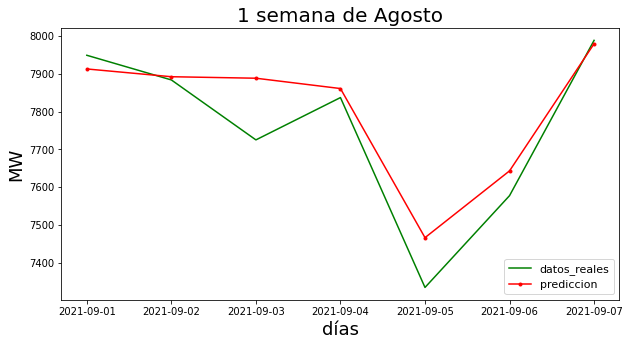

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(index_1_semana, semana_1, c='g', label = 'datos_reales')
plt.plot(index_1_semana, hibrido2_1_semana, '.-r', label = 'prediccion')
plt.title('1 semana de Agosto', fontsize = 20)
plt.xlabel('días', fontsize = 18)
plt.ylabel('MW', fontsize = 18)
plt.legend(loc = 'lower right', fontsize = 11)
plt.show()

**Probando predecir 2 semanas**

In [ ]:
hibrido2_2_semana_norm = predictions(norm_input_test, model_sen_dmin_hibrido2, PREDICT_2_WEEK)

In [ ]:
hibrido2_2_semana= SCALER.inverse_transform(hibrido2_2_semana_norm)

In [ ]:
results_hibrido2_2 = {
    'MSE': round(float(mean_squared_error(semana_2, hibrido2_2_semana)),6),
    'MAE': round(float(mean_absolute_error(semana_2, hibrido2_2_semana)),6),
    'MAPE': round(float(mape(semana_2, hibrido2_2_semana)),6)
    }
results_hibrido2_2

{'MAE': 116.958818, 'MAPE': 1.478423, 'MSE': 21338.313718}

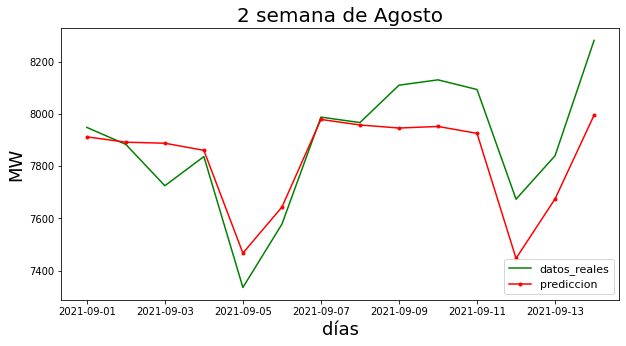

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(index_2_semana, semana_2, c='g', label = 'datos_reales')
plt.plot(index_2_semana, hibrido2_2_semana, '.-r', label = 'prediccion')
plt.title('2 semana de Agosto', fontsize = 20)
plt.xlabel('días', fontsize = 18)
plt.ylabel('MW', fontsize = 18)
plt.legend(loc = 'lower right', fontsize = 11)
plt.show()

**Probando predecir 3 semanas**

In [ ]:
hibrido2_3_semana_norm = predictions(norm_input_test, model_sen_dmin_hibrido2, PREDICT_3_WEEK)

In [ ]:
hibrido2_3_semana= SCALER.inverse_transform(hibrido2_3_semana_norm)

In [ ]:
results_hibrido2_3 = {
    'MSE': round(float(mean_squared_error(semana_3, hibrido2_3_semana)),6),
    'MAE': round(float(mean_absolute_error(semana_3, hibrido2_3_semana)),6),
    'MAPE': round(float(mape(semana_3, hibrido2_3_semana)),6)
    }
results_hibrido2_3

{'MAE': 136.436041, 'MAPE': 1.758544, 'MSE': 33326.657568}

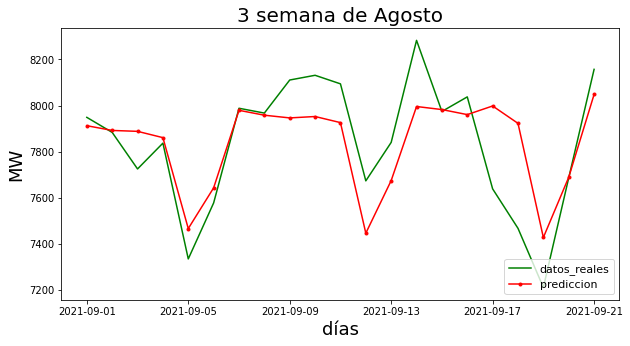

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(index_3_semana, semana_3, c='g', label = 'datos_reales')
plt.plot(index_3_semana, hibrido2_3_semana, '.-r', label = 'prediccion')
plt.title('3 semana de Agosto', fontsize = 20)
plt.xlabel('días', fontsize = 18)
plt.ylabel('MW', fontsize = 18)
plt.legend(loc = 'lower right', fontsize = 11)
plt.show()

**Probando predecir 4 semanas**

In [ ]:
hibrido2_4_semana_norm = predictions(norm_input_test, model_sen_dmin_hibrido2, PREDICT_4_WEEK)

In [ ]:
hibrido2_4_semana= SCALER.inverse_transform(hibrido2_4_semana_norm)

In [ ]:
results_hibrido2_4 = {
    'MSE': round(float(mean_squared_error(semana_4, hibrido2_4_semana)),6),
    'MAE': round(float(mean_absolute_error(semana_4, hibrido2_4_semana)),6),
    'MAPE': round(float(mape(semana_4, hibrido2_4_semana)),6)
    }
results_hibrido2_4

{'MAE': 124.054338, 'MAPE': 1.593819, 'MSE': 27788.189591}

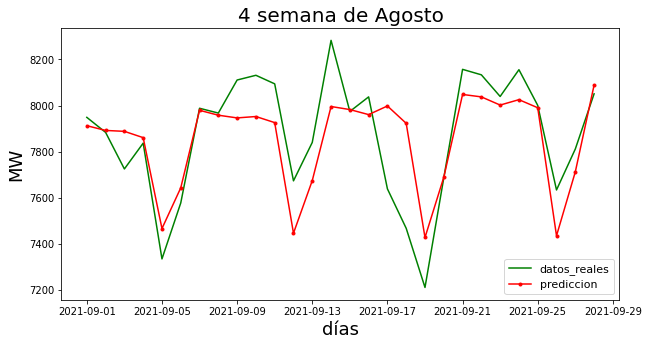

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(index_4_semana, semana_4, c='g', label = 'datos_reales')
plt.plot(index_4_semana, hibrido2_4_semana, '.-r', label = 'prediccion')
plt.title('4 semana de Agosto', fontsize = 20)
plt.xlabel('días', fontsize = 18)
plt.ylabel('MW', fontsize = 18)
plt.legend(loc = 'lower right', fontsize = 11)
plt.show()

## RESUMEN

**Prediciendo 1 semana de septiembre 2021 (dmin)**

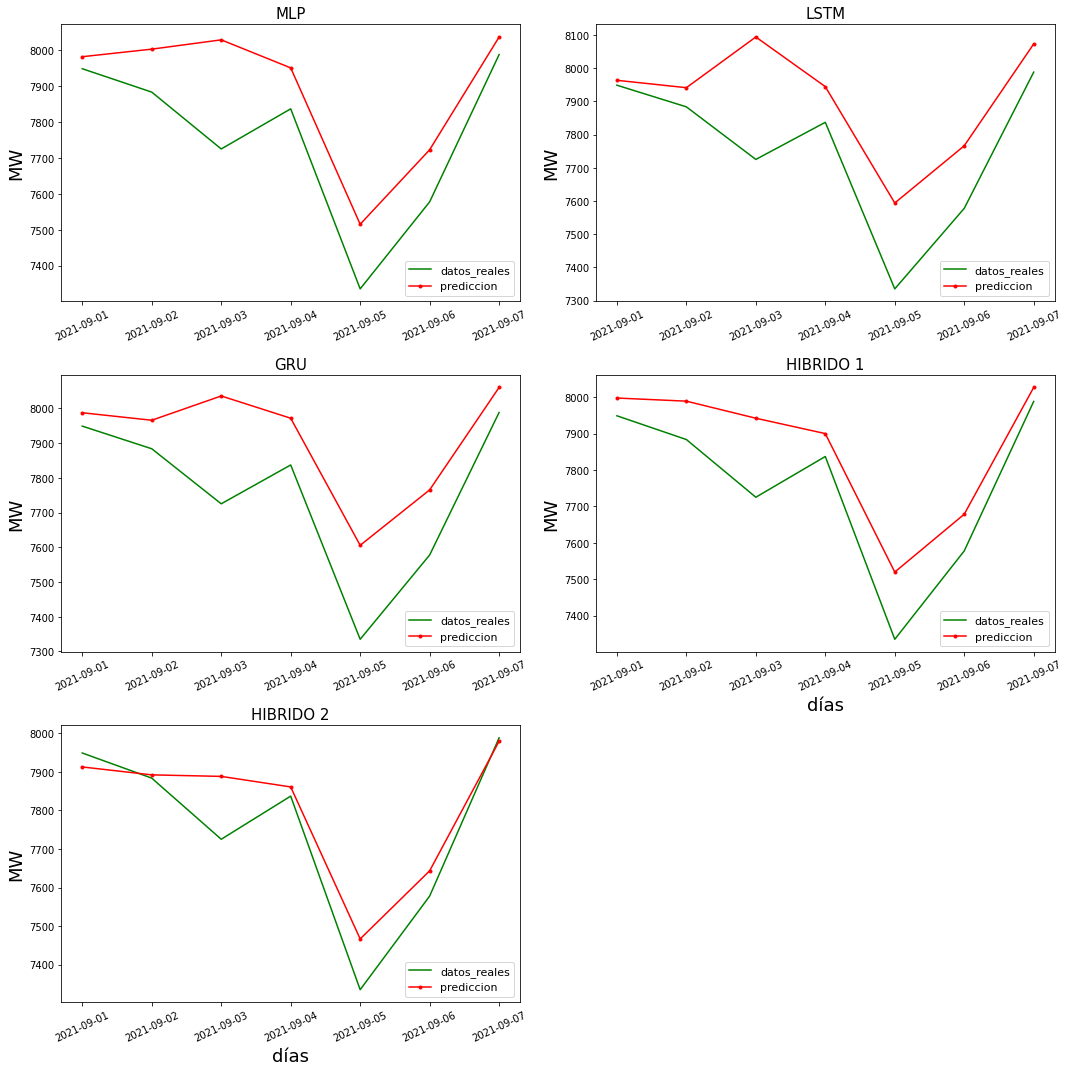

In [ ]:
resumen_graficas(index_1_semana, semana_1, mlp_1_semana, lstm_1_semana, gru_1_semana, hibrido1_1_semana, hibrido2_1_semana, legend='lower right')

**Prediciendo 2 semanas de septiembre 2021 (dmin)**

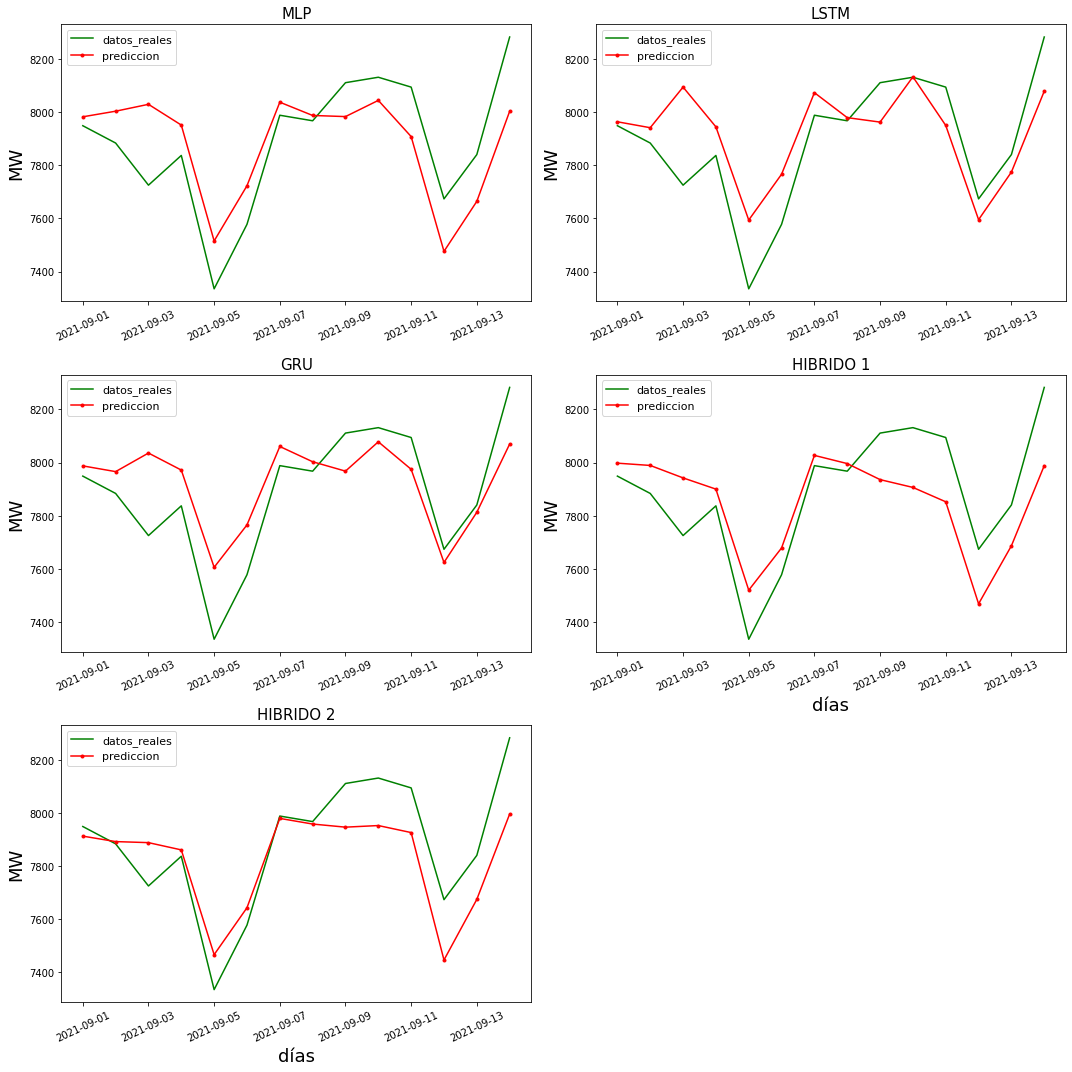

In [ ]:
resumen_graficas(index_2_semana, semana_2, mlp_2_semana, lstm_2_semana, gru_2_semana, hibrido1_2_semana, hibrido2_2_semana, legend='upper left')

**Prediciendo 3 semanas de septiembre 2021 (dmin)**

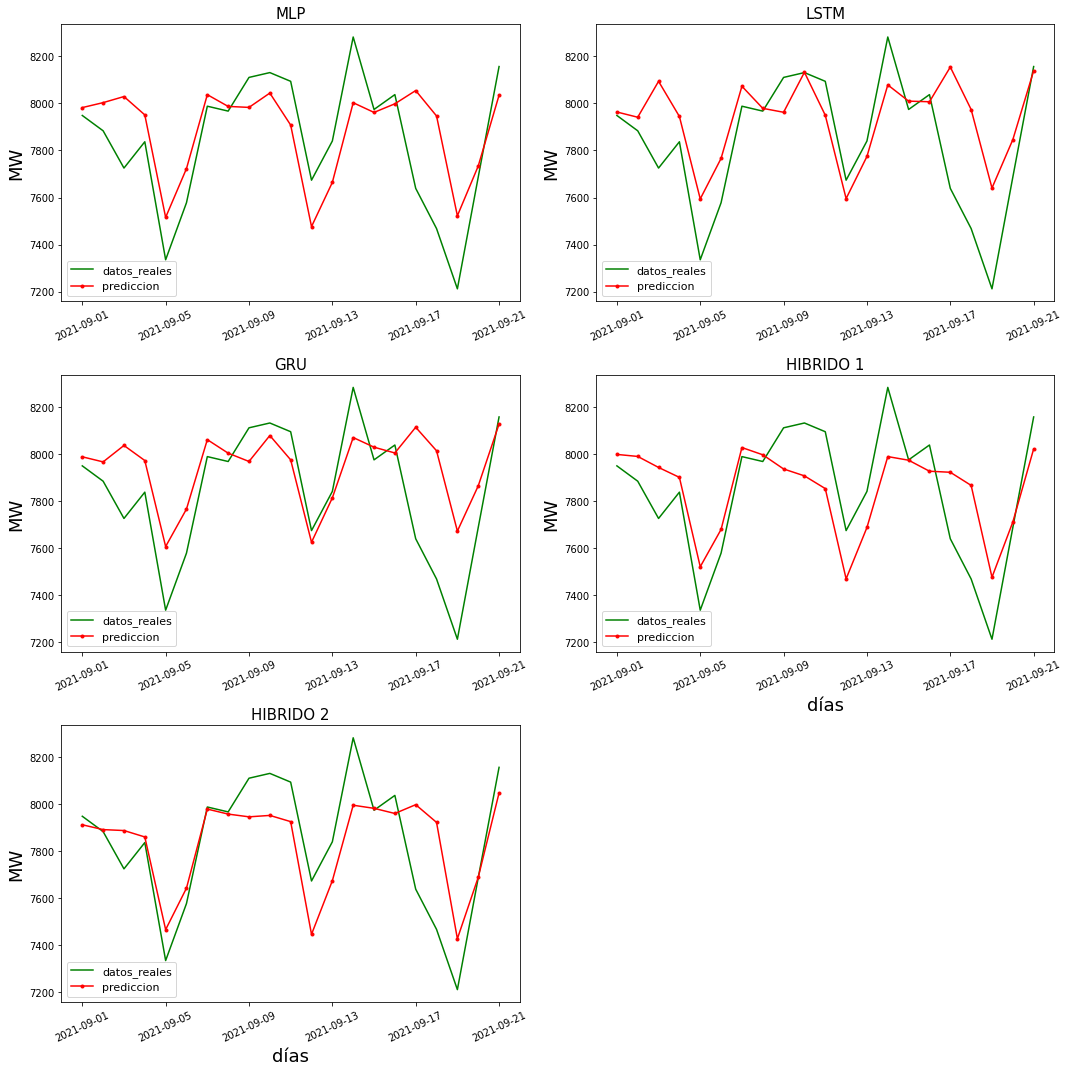

In [ ]:
resumen_graficas(index_3_semana, semana_3, mlp_3_semana, lstm_3_semana, gru_3_semana, hibrido1_3_semana, hibrido2_3_semana, legend='lower left')

**Prediciendo 4 semanas de septiembre 2021 (dmin)**

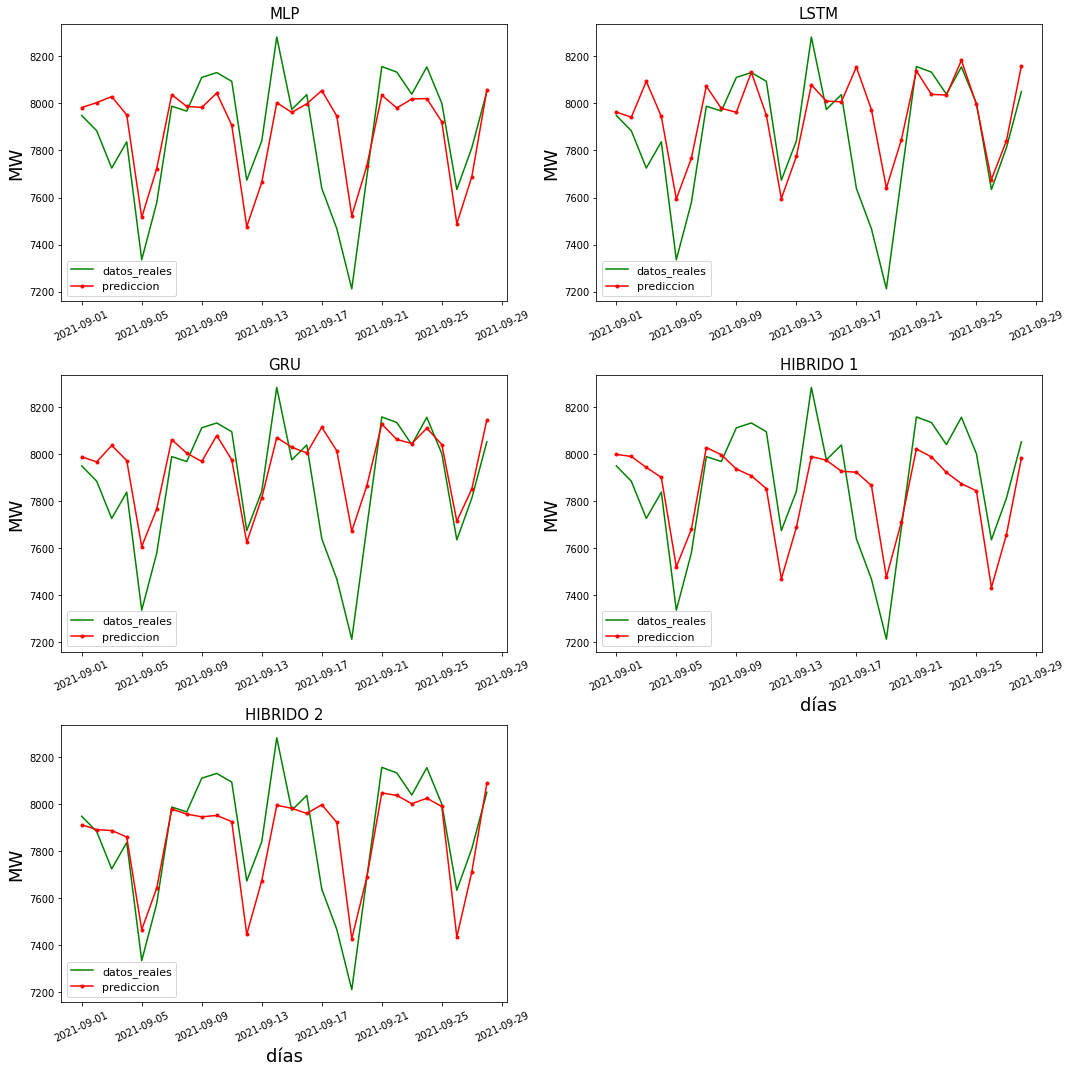

In [ ]:
resumen_graficas(index_4_semana, semana_4, mlp_4_semana, lstm_4_semana, gru_4_semana, hibrido1_4_semana, hibrido2_4_semana, legend='lower left')

In [ ]:
df_1 = pd.DataFrame([results_mlp_1, results_lstm_1, results_gru_1, results_hibrido1_1, results_hibrido2_1], index = ['MLP','LSTM','GRU','HIBRIDO1','HIBRIDO2']).transpose()
df_2 =  pd.DataFrame([results_mlp_2, results_lstm_2, results_gru_2, results_hibrido1_2, results_hibrido2_2], index = ['MLP','LSTM','GRU','HIBRIDO1','HIBRIDO2']).transpose()
df_3 =  pd.DataFrame([results_mlp_3, results_lstm_3, results_gru_3, results_hibrido1_3, results_hibrido2_3], index = ['MLP','LSTM','GRU','HIBRIDO1','HIBRIDO2']).transpose()
df_4 =  pd.DataFrame([results_mlp_4, results_lstm_4, results_gru_4, results_hibrido1_4, results_hibrido2_4], index = ['MLP','LSTM','GRU','HIBRIDO1','HIBRIDO2']).transpose()

In [ ]:
resumen = pd.concat([df_1,df_2,df_3,df_4], ignore_index= True)

In [ ]:
semanas = ['1 semana','1 semana', '1 semana', '2 semanas','2 semanas','2 semanas',
           '3 semanas','3 semanas','3 semanas', '4 semanas','4 semanas','4 semanas']
metricas = ['MSE','MAE','MAPE','MSE','MAE','MAPE','MSE','MAE','MAPE','MSE','MAE','MAPE']

In [ ]:
resumen['Metricas'] = metricas
resumen['Tiempo de prediccion'] = semanas

In [ ]:
resumen.sort_values('Metricas', inplace=True)

In [ ]:
index_resumen = pd.DataFrame(resumen[['Metricas','Tiempo de prediccion']])
index_resumen = pd.MultiIndex.from_frame(index_resumen)
resumen = resumen.iloc[:,:-2]
resumen = resumen.set_index(index_resumen)

In [ ]:
resumen

MLP          LSTM           GRU  \
Metricas Tiempo de prediccion                                             
MAE      1 semana                135.186614    154.476217    156.568169   
         2 semanas               144.303746    123.931766    124.132897   
         3 semanas               164.140478    163.337261    167.290483   
         4 semanas               146.679829    133.672131    138.828691   
MAPE     1 semana                  1.760662      2.020930      2.047057   
         2 semanas                 1.836705      1.588796      1.588884   
         3 semanas                 2.125605      2.135714      2.186333   
         4 semanas                 1.890996      1.741374      1.807679   
MSE      1 semana              25292.074176  37289.957883  33766.907149   
         2 semanas             27438.496035  25427.419880  23141.232181   
         3 semanas             42956.699954  51943.181078  52122.803981   
         4 semanas             35231.538769  39831.781775  40002.052167   

                                   HIBRIDO1      HIBRIDO2  
Metricas Tiempo de prediccion                              
MAE      1 semana                108.282340     62.514801  
         2 semanas               148.693071    116.958818  
         3 semanas               157.091882    136.436041  
         4 semanas               158.229273    124.054338  
MAPE     1 semana                  1.412981      0.821155  
         2 semanas                 1.882200      1.478423  
         3 semanas                 2.020047      1.758544  
         4 semanas                 2.022239      1.593819  
MSE      1 semana              15750.882910   7175.505617  
         2 semanas             28800.838347  21338.313718  
         3 semanas             35367.162576  33326.657568  
         4 semanas             34025.741054  27788.189591